# Mobility in Tokyo

- Data source: NTT DoCoMo's [Mobile Kukan Toukei](https://mobaku.jp/)
    - “Mobile Kukan Toukei” is a trademark of NTT DOCOMO, INC.
    - NTT DOCOMO’s “Mobile Kukan Toukei” services are only available to subscribers in Japan.


In [1]:
# This code should run as a separate .py file in a command line.
# Running it in Notebook is *very* slow

import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import pickle

data_dir = "f:/Users/Hiroshi/Desktop/DoCoMo/"
cache_dir = data_dir + "cache/"
debug = True

def read_cluster(cluster_fn):
    pred = None
    if os.path.exists(cluster_fn):
        with open(cluster_fn, 'rb') as f:
            pred = pickle.load(f)
        print('Using saved cluster', cluster_fn)
    return pred

cluster = read_cluster(cache_dir + 'cluster.pickle')     

patterns = {"00000":["area"], 
            "00000_c": ["area"],
            "00001":["area", "age", "gender"],
            "00001_c":["area", "age", "gender"],
            "00002_c":["area", "residence"],
            "00003":["residence"]}

tables = {}

def read_cache(pattern):
    fn = cache_dir + pattern + ".pickle"
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            return pickle.load(f)
    else:
        return None

def read_hourly_data(pattern, d, h):
    d_str = d.strftime("%Y%m%d")
    d_h = d + pd.Timedelta('{} hours'.format(h))
    fn = data_dir + "s3/realtime/{}/clipped_mesh_pop_{}{:02d}00_{}.csv.zip" \
      .format(d_str, d_str, h, pattern[0:5])
    print("Reading {}...".format(fn))
    if os.path.exists(fn):
        with open(fn, 'rb') as f:
            hourly = pd.read_csv(fn, usecols=patterns[pattern] + ["population"], dtype={"area": str})
            hourly = hourly.set_index(patterns[pattern])
            hourly.rename(columns={"population": d_h}, inplace=True)
    else:
        hourly = pd.DataFrame(columns=patterns[pattern] + ["population"])
        hourly.set_index(patterns[pattern], inplace=True)
        hourly.rename(columns={"population": d_h}, inplace=True)
    return hourly

def add_hour(pattern, t_1, t, m):
    if debug:
        print("t-1")
        display(t_1)
        print("t")
        display(t)
    # 1. Calculate Norm
    df = t_1.merge(t, how='outer', left_index=True, right_index=True).fillna(0)
    if debug:
        print("After merge")
        display(df)
    norm = df.diff(axis=1).abs()
    norm.reset_index(inplace=True)
    norm.set_index("area", inplace=True)
    if debug:
        print("Norm")
        display(norm)
    # 2. Join category
    df = norm.merge(cluster, how='right', left_index=True, right_index=True).fillna(0)
    df.rename(columns={0:"cluster"}, inplace=True)

    if debug:
        print("With category")
        display(df)
    # 3. Group them
    df = df.groupby(["cluster"] + patterns[pattern][1:]).mean()
    if debug:
        print("Grouped by")
        display(df)
        print("m")
        display(m)
    # 4. Merge it to m
    df = m.merge(df.iloc[:,1], how='outer', left_index=True, right_index=True).fillna(0)
    if debug:
        print("mobility_by_category")
        display(df)
    return df

def update_cache(pattern, end_date=None):
    mobility_by_cat = read_cache(pattern)
    if mobility_by_cat is None:        
        start_date = pd.to_datetime("2020-01-01")
        # mobility_by_cat = pd.DataFrame(columns=patterns[pattern] + ["population"])
        # mobility_by_cat = mobility_by_cat .set_index(patterns[pattern])
        # mobility_by_cat.rename(columns={"population": start_date}, inplace=True)
        mobility_by_cat = pd.DataFrame(columns=["cluster"] + patterns[pattern][1:])
        mobility_by_cat.set_index(["cluster"] + patterns[pattern][1:], inplace=True)
        # print(mobility_by_cat)
    else:
        start_date = pd.to_datetime(mobility_by_cat.columns[-1]) + pd.Timedelta('1 days')
    if end_date is None:
        end_date = pd.Timestamp.today() - pd.Timedelta('1 days')
    dates_to_add = pd.date_range(start=start_date.date(), end=end_date)
    # print(dates_to_add)
    hourly_last = read_hourly_data(pattern, dates_to_add[0] - pd.Timedelta('1 day'), 23) # 前日の23時
    for d in dates_to_add:
        for h in range(24):
            hourly = read_hourly_data(pattern, d, h)
            mobility_by_cat = add_hour(pattern, hourly_last, hourly, mobility_by_cat)
            hourly_last = hourly
            if debug and h > 1:
                return
               
    with open(cache_dir + pattern + ".pickle", 'wb') as f:
        pickle.dump(mobility_by_cat, f)

def read_table(pattern):
    update_cache(pattern)
    tables[pattern] = read_cache(pattern)

# update_cache("00001_c", end_date=pd.to_datetime("2020-01-01"))

# update_cache("00000", end_date=pd.to_datetime("2020-02-29"))
# t = read_hourly_data("00000", pd.to_datetime("2020-01-01"), 0)
# pred.merge(t, left_index=True, right_index=True, how='left').groupby(0).sum()
print('Done')

Using saved cluster f:/Users/Hiroshi/Desktop/DoCoMo/cache/cluster.pickle
Done


### Plot mobility by cluster and investigate the anomaly
- Cluster 3 is night areas (e.g., Shinjuku, Shibuya)
    - '533935952' '533945254' '533945263' '533945361' '533945764' '533946013'
- It has anomaly on Feb. 19, at 5pm and 8pm
    - Especially Shinjuku and Ikebukuro. The cell populations are 10,000 ~ 20,000 higher than normal

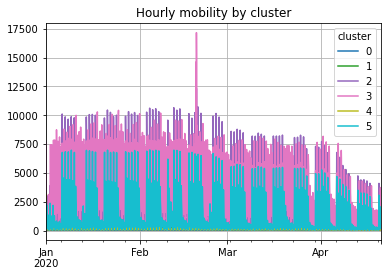

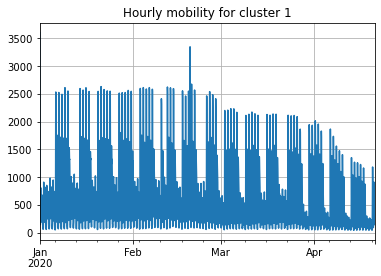

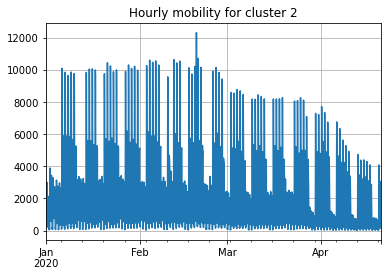

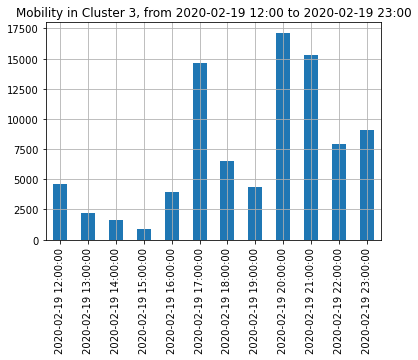

In [2]:
t = read_cache("00000_c")

t.T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility by cluster")
plt.show()

t.loc[1,:].T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility for cluster 1")
plt.show()

t.loc[2,:].T.plot(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Hourly mobility for cluster 2")
plt.show()

t.loc[3,"2020-02-19 12:00":"2020-02-19 23:00"].T.plot.bar(cmap=plt.get_cmap("tab10"), grid=True)
plt.title("Mobility in Cluster 3, from 2020-02-19 12:00 to 2020-02-19 23:00")
plt.show()

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002191900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200219/clipped_mesh_pop_202002192100_00001.csv.zip...


area,渋谷文化村前,新宿西口,新宿南口,新宿歌舞伎町,池袋西口,銀座三丁目
2020-02-19 16:00:00,40523,55501,48710,47269,41674,44460
2020-02-19 17:00:00,51974,69602,65330,60244,63129,55524
2020-02-19 18:00:00,55562,70873,74568,70914,74963,57864
2020-02-19 19:00:00,57608,63149,70294,76703,73823,52661
2020-02-19 20:00:00,48243,43028,48711,64747,50037,36531
2020-02-19 21:00:00,35608,27422,31919,50948,32267,21438


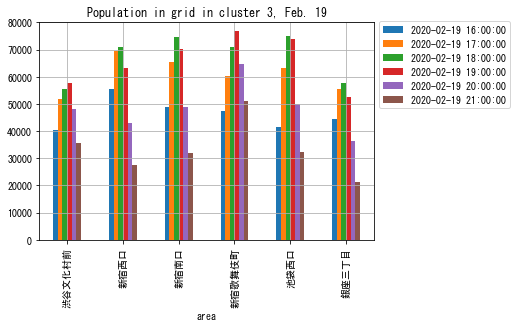

Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121600_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121700_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121800_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002121900_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122000_00001.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200212/clipped_mesh_pop_202002122100_00001.csv.zip...


area,渋谷文化村前,新宿西口,新宿南口,新宿歌舞伎町,池袋西口,銀座三丁目
2020-02-12 16:00:00,39220,54628,47898,45566,44993,44142
2020-02-12 17:00:00,41371,56372,51417,47761,48499,43567
2020-02-12 18:00:00,43763,55535,55807,53584,53325,44098
2020-02-12 19:00:00,44481,48326,51430,57820,50847,39426
2020-02-12 20:00:00,42974,38246,41890,55975,43989,31327
2020-02-12 21:00:00,36564,28818,32311,50488,35261,21849


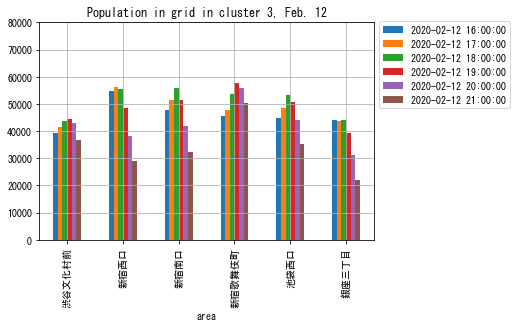

time: 18.9 s


In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

# Check to see which grid cell has the anomaly
cluster3 = cluster[cluster[0] == 3]
cellnames = {'533935952':"渋谷文化村前",
             '533945254':"新宿西口",
             '533945263':"新宿南口",
             '533945361':"新宿歌舞伎町",
             '533945764':"池袋西口",
             '533946013':"銀座三丁目"
            }
#print(cellnames.values())

#print(cluster3.index.values)
# print('533935952' in cluster3.index)

def read_hourly_data_in_cluster(pattern, date, hour, cluster):
    df = read_hourly_data(pattern, date, hour).reset_index()
    df = df[df.area.isin(cluster)]
    return df



rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-19"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 19")
plt.show()

# for comparison, show the dame data for one week before
rows = [read_hourly_data_in_cluster("00001", pd.to_datetime("2020-02-12"), h, cluster3.index.values) \
           .groupby("area").sum().iloc[:,2]
           for h in range(16,22)
          ]
t = pd.DataFrame(rows).rename(columns=cellnames)
display(t)
t.T.plot.bar(grid=True, ylim=[0, 80000]).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.title("Population in grid in cluster 3, Feb. 12")
plt.show()


# feb19_20 = feb19_20.merge(cluster, how="inner", left_on="area", right_index=True).rename(columns={0:"cluster"})
#feb19_20[feb19_20.cluster==3].groupby("area").sum()
#feb19_20.groupby("area").sum()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
2020-04-21
['gender'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
0       15  1                  5.826898             5.710985   
            2                  4.727968             4.922247   
        20  1                  6.268140             6.481059   
            2                  5.749328             5.872324   
        30  1                  6.036661             6.004712   
...                                 ...                  ...   
5       50  2                 17.659091            14.840909   
        60  1                 11.454545             9.613636   
            2                  8.363636             6.386364   
        70  1                  5.840909             6.090909   
            2                  8.159091             7.227273   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
0       15  1                  5.505236             5.248035   
            2                  4.666063             4.528694   
        20  1                  6.257698             6.218601   
            2                  5.621984             5.638568   
        30  1                  6.184258             5.827299   
...                                 ...                  ...   
5       50  2                 11.886364             9.772727   
        60  1                  9.363636             8.886364   
            2                  6.636364             6.704545   
        70  1                  5.372093             5.727273   
            2                  6.386364             7.227273   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
0       15  1                  5.268462             5.857266   
            2                  4.436735             5.092362   
        20  1                  6.195415             6.554308   
            2                  5.539810             5.855253   
        30  1                  5.881004             6.446302   
...                                 ...                  ...   
5       50  2                 12.136364            15.522727   
        60  1                  9.681818            38.954545   
            2                 10.613636            10.090909   
        70  1                  6.318182            10.977273   
            2                 10.409091             9.022727   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
0       15  1                  6.154600             8.476151   
            2                  5.704325             7.453473   
        20  1                  7.081412             7.765569   
            2                  6.229096             7.057993   
        30  1                  7.442646             7.557389   
...                                 ...                  ...   
5       50  2                 77.250000           166.954545   
        60  1                 84.022727            91.068182   
            2                 23.500000            46.795455   
        70  1                 13.454545            18.977273   
            2                  9.681818            12.613636   

                    2020-01-01 09:00:00  2020-01-01 10:00:00  ...  \
cluster age gender                                            ...   
0       15  1                  6.588761             6.613276  ...   
            2                  6.328815             6.458517  ...   
        20  1                  7.236071             6.645714  ...   
            2                  6.596954             6.309125  ...   
        30  1                  7.031930             6.924384  ...   
...                                 ...                  ...  ...   
5       50  2                 67.431818            66.045455  ...   
        60  1                 24.409091            36.204545  ...  

Groupby ['gender']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
gender,,,,,,,,,,,,,,,,,,,,,
1,1115.457362,1019.704622,724.428388,787.295065,1076.667402,1892.726064,3854.328185,4121.333517,1864.352582,2349.504222,...,583.064962,807.549739,906.580406,1837.389938,3456.694881,5071.381405,4899.146491,3485.537995,2140.567220,1316.440884
2,1011.172672,1405.044833,711.250947,685.058862,978.905680,1144.510520,2603.945661,4075.171382,2240.346066,2386.774544,...,553.655982,729.076609,923.795288,1781.325569,3058.236112,4330.667121,3419.174258,1901.621366,857.891006,468.583750


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
gender,,,,,,,,,,,,,,,,,,,,,
1,4736.700988,4724.869293,4729.964577,4751.730939,4771.278724,4774.898318,4794.361877,4799.871993,4799.254201,4750.502352,...,2440.689153,2280.414594,2132.018088,2049.164132,1989.191830,1934.642683,1906.014674,1902.972223,1872.902074,1844.115756
2,4589.863218,4565.071884,4558.729345,4588.236059,4601.936605,4600.903101,4608.066324,4622.633477,4640.077986,4635.378985,...,2002.822339,1821.055498,1651.598856,1577.995680,1527.357706,1478.054144,1454.838280,1450.019081,1426.573474,1405.015692


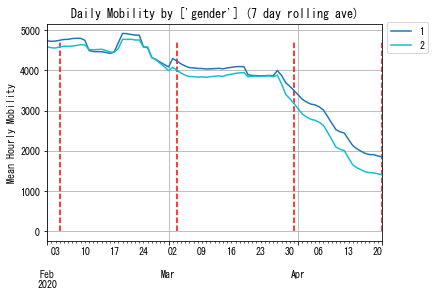

gender,1,2
2020-03-03,-0.108923,-0.127000
2020-03-31,-0.264139,-0.307947
2020-04-21,-0.611907,-0.693779


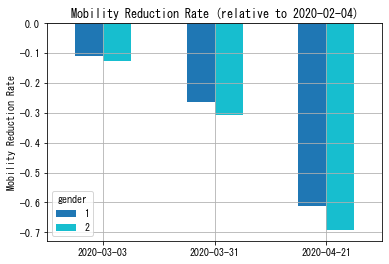

['age'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
0       15  1                  5.826898             5.710985   
            2                  4.727968             4.922247   
        20  1                  6.268140             6.481059   
            2                  5.749328             5.872324   
        30  1                  6.036661             6.004712   
...                                 ...                  ...   
5       50  2                 17.659091            14.840909   
        60  1                 11.454545             9.613636   
            2                  8.363636             6.386364   
        70  1                  5.840909             6.090909   
            2                  8.159091             7.227273   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
0       15  1                  5.505236             5.248035   
            2                  4.666063             4.528694   
        20  1                  6.257698             6.218601   
            2                  5.621984             5.638568   
        30  1                  6.184258             5.827299   
...                                 ...                  ...   
5       50  2                 11.886364             9.772727   
        60  1                  9.363636             8.886364   
            2                  6.636364             6.704545   
        70  1                  5.372093             5.727273   
            2                  6.386364             7.227273   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
0       15  1                  5.268462             5.857266   
            2                  4.436735             5.092362   
        20  1                  6.195415             6.554308   
            2                  5.539810             5.855253   
        30  1                  5.881004             6.446302   
...                                 ...                  ...   
5       50  2                 12.136364            15.522727   
        60  1                  9.681818            38.954545   
            2                 10.613636            10.090909   
        70  1                  6.318182            10.977273   
            2                 10.409091             9.022727   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
0       15  1                  6.154600             8.476151   
            2                  5.704325             7.453473   
        20  1                  7.081412             7.765569   
            2                  6.229096             7.057993   
        30  1                  7.442646             7.557389   
...                                 ...                  ...   
5       50  2                 77.250000           166.954545   
        60  1                 84.022727            91.068182   
            2                 23.500000            46.795455   
        70  1                 13.454545            18.977273   
            2                  9.681818            12.613636   

                    2020-01-01 09:00:00  2020-01-01 10:00:00  ...  \
cluster age gender                                            ...   
0       15  1                  6.588761             6.613276  ...   
            2                  6.328815             6.458517  ...   
        20  1                  7.236071             6.645714  ...   
            2                  6.596954             6.309125  ...   
        30  1                  7.031930             6.924384  ...   
...                                 ...                  ...  ...   
5       50  2                 67.431818            66.045455  ...   
        60  1                 24.409091            36.204545  ...  

Groupby ['age']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
age,,,,,,,,,,,,,,,,,,,,,
15,275.505879,258.511742,169.291742,156.402599,215.478788,267.372138,324.796685,242.652595,216.892323,244.194918,...,98.138645,109.976926,110.419281,133.241238,229.238854,202.875998,154.070497,151.343858,106.011538,78.313441
20,727.232082,876.348252,451.639758,463.965502,777.722542,850.988704,1255.582776,1864.093716,949.764517,926.628154,...,205.923595,229.573043,271.095385,544.392149,1044.518512,2017.535482,2115.281635,1442.656514,832.970457,499.616077
30,334.925477,426.753751,262.856001,298.263484,364.017528,422.380817,1346.611175,2226.530980,1005.737095,1022.099952,...,227.723430,284.699957,315.019353,680.953495,1187.019687,1991.642343,2041.916766,1363.434678,787.720379,516.004823
40,308.440266,371.906720,211.889017,197.204757,280.226102,499.728753,1576.645480,1999.861945,799.484900,1017.232716,...,209.664612,272.377197,379.362382,740.111237,1432.293365,2106.309531,1947.816257,1271.343847,702.881529,381.341736
50,282.189719,281.923538,173.797960,180.460975,206.387092,543.885962,1285.146406,1222.324518,497.894795,765.461948,...,154.423230,224.288559,299.391209,719.930663,1360.606598,1982.136955,1508.133613,832.921223,395.461895,169.944753
60,121.319536,122.821451,85.820242,104.069434,119.917302,326.207002,534.693225,472.371097,332.609987,423.504130,...,140.430402,224.986504,252.432557,557.095429,961.923229,892.077059,422.365614,236.562059,114.312808,81.072734
70,77.017076,86.484001,80.384615,71.987177,91.823727,126.673208,134.798098,168.670048,302.315031,337.156949,...,100.417030,190.724161,202.655528,242.991296,299.330748,209.471158,128.736367,88.897182,59.099622,58.731070


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
age,,,,,,,,,,,,,,,,,,,,,
15,538.376484,541.407811,546.735686,548.526888,557.927796,562.688191,575.072664,580.965559,581.758546,583.886442,...,153.387415,141.251377,133.746373,131.139251,129.235066,126.804596,124.246344,123.395781,122.254853,120.224839
20,2470.068990,2455.640263,2453.645100,2466.572792,2473.108835,2473.853291,2479.888109,2485.795592,2491.149029,2484.561954,...,1046.011584,950.694315,863.130598,822.419718,794.710620,768.344886,754.093071,750.703006,736.502306,723.532906
30,1969.653050,1959.314883,1958.296465,1968.488066,1972.746506,1972.669305,1973.340086,1974.739863,1979.706009,1962.190781,...,993.738329,918.574309,845.426780,806.967375,781.050827,757.279308,745.892574,744.167189,731.573868,720.150565
40,1815.833479,1810.880913,1810.717207,1818.668776,1824.777780,1826.040087,1830.267363,1832.140096,1835.962099,1819.834636,...,947.495999,880.700060,815.640140,780.453976,755.238550,732.299255,722.344061,721.222866,708.747483,697.527737
50,1452.396641,1449.309937,1449.304224,1455.474320,1461.076547,1461.685514,1464.996601,1468.533818,1470.045125,1459.119921,...,755.967935,700.052129,646.644888,619.813089,599.993240,581.596229,574.171856,573.142676,563.715705,555.170513
60,725.995586,721.622405,719.094013,724.242394,725.345879,723.697186,723.911752,724.962862,725.419830,721.187673,...,383.214571,356.483578,332.385264,321.732929,313.457820,305.748202,301.709008,301.472008,297.984857,294.681377
70,354.239975,351.764965,350.901227,357.993762,358.231987,355.167845,354.951629,355.367680,355.291549,355.099930,...,163.695659,153.714324,146.642902,144.633473,142.863413,140.624352,138.396039,138.887777,138.696476,137.843513


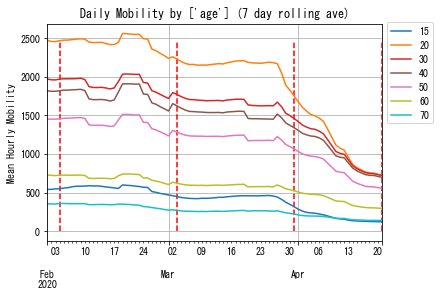

age,15,20,30,40,50,60,70
2020-03-03,-0.183897,-0.096894,-0.100897,-0.107742,-0.118731,-0.143321,-0.249274
2020-03-31,-0.422851,-0.290744,-0.259272,-0.263850,-0.268977,-0.277374,-0.380896
2020-04-21,-0.780822,-0.706665,-0.634161,-0.616462,-0.618564,-0.593118,-0.614956


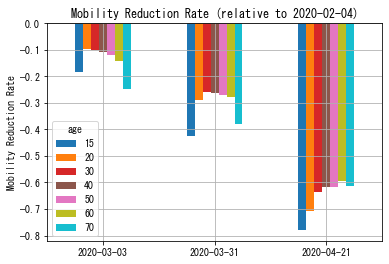

['cluster'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
0       15  1                  5.826898             5.710985   
            2                  4.727968             4.922247   
        20  1                  6.268140             6.481059   
            2                  5.749328             5.872324   
        30  1                  6.036661             6.004712   
...                                 ...                  ...   
5       50  2                 17.659091            14.840909   
        60  1                 11.454545             9.613636   
            2                  8.363636             6.386364   
        70  1                  5.840909             6.090909   
            2                  8.159091             7.227273   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
0       15  1                  5.505236             5.248035   
            2                  4.666063             4.528694   
        20  1                  6.257698             6.218601   
            2                  5.621984             5.638568   
        30  1                  6.184258             5.827299   
...                                 ...                  ...   
5       50  2                 11.886364             9.772727   
        60  1                  9.363636             8.886364   
            2                  6.636364             6.704545   
        70  1                  5.372093             5.727273   
            2                  6.386364             7.227273   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
0       15  1                  5.268462             5.857266   
            2                  4.436735             5.092362   
        20  1                  6.195415             6.554308   
            2                  5.539810             5.855253   
        30  1                  5.881004             6.446302   
...                                 ...                  ...   
5       50  2                 12.136364            15.522727   
        60  1                  9.681818            38.954545   
            2                 10.613636            10.090909   
        70  1                  6.318182            10.977273   
            2                 10.409091             9.022727   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
0       15  1                  6.154600             8.476151   
            2                  5.704325             7.453473   
        20  1                  7.081412             7.765569   
            2                  6.229096             7.057993   
        30  1                  7.442646             7.557389   
...                                 ...                  ...   
5       50  2                 77.250000           166.954545   
        60  1                 84.022727            91.068182   
            2                 23.500000            46.795455   
        70  1                 13.454545            18.977273   
            2                  9.681818            12.613636   

                    2020-01-01 09:00:00  2020-01-01 10:00:00  ...  \
cluster age gender                                            ...   
0       15  1                  6.588761             6.613276  ...   
            2                  6.328815             6.458517  ...   
        20  1                  7.236071             6.645714  ...   
            2                  6.596954             6.309125  ...   
        30  1                  7.031930             6.924384  ...   
...                                 ...                  ...  ...   
5       50  2                 67.431818            66.045455  ...   
        60  1                 24.409091            36.204545  ...  

Groupby ['cluster']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
cluster,,,,,,,,,,,,,,,,,,,,,
0,76.755237,77.474284,76.030621,74.451581,74.457102,81.833202,88.490862,96.415602,90.805965,89.816146,...,80.904450,81.324146,82.298860,87.962380,97.074016,92.548622,84.405895,78.489884,74.122467,73.715424
1,350.249553,516.544723,270.602286,214.223077,206.867501,263.574061,576.623077,849.630769,512.653846,516.230769,...,177.121959,213.176562,254.379230,451.913999,766.324532,905.905929,700.694453,481.740160,293.786426,197.328631
2,605.529412,458.058824,249.058824,267.588235,464.882353,851.470588,2250.882353,3050.941176,1202.941176,1406.470588,...,225.647059,360.117647,472.117647,1023.352941,2109.823529,2874.823529,2331.742081,1532.101244,767.780556,398.205042
3,673.333333,1009.000000,546.500000,641.000000,991.666667,1401.333333,2290.166667,1819.666667,1110.666667,1595.166667,...,318.833333,434.500000,463.666667,887.666667,1475.666667,3383.333333,3653.333333,2274.000000,1244.166667,727.933333
4,114.755100,114.148897,108.365511,104.704670,105.313094,122.775399,166.179069,200.759776,177.653722,162.117324,...,124.282324,125.394356,129.686018,156.433156,192.937070,191.655450,166.744006,142.694997,122.384591,113.260667
5,306.007400,249.522727,185.122093,170.386364,212.386364,316.250000,1085.931818,2179.090909,1009.977273,966.477273,...,209.931818,322.113636,428.227273,1011.386364,1873.105180,1953.781661,1381.400981,878.133075,496.217520,274.581536


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
cluster,,,,,,,,,,,,,,,,,,,,,
0,94.198681,94.340731,94.446482,94.696350,94.667357,94.557805,94.687361,94.526518,94.404430,94.127641,...,83.463493,82.618125,82.160639,81.879147,81.642751,81.236071,80.905433,81.159952,81.229897,81.086139
1,814.258307,814.441423,815.642205,820.310216,823.281236,822.953057,828.911750,830.672681,831.020258,821.520115,...,446.813595,419.046090,394.687108,380.986512,370.834286,361.497208,357.438675,357.604002,352.654496,348.291549
2,2653.226538,2640.901136,2641.250444,2656.692829,2669.891072,2673.356668,2679.584267,2686.155958,2691.132586,2657.165615,...,1246.688062,1148.514644,1057.650178,1008.759048,974.240419,943.068754,930.730974,928.980716,910.584646,895.264066
3,4091.449603,4068.665873,4063.143849,4085.837302,4095.179563,4092.685516,4098.123016,4108.691468,4120.991071,4137.667659,...,1670.317361,1515.794742,1369.089782,1307.480060,1265.609821,1224.941865,1196.048016,1189.696825,1172.283730,1152.478472
4,198.630256,198.825356,198.887488,199.343059,199.449351,199.549625,200.312685,200.185000,200.356816,199.114195,...,149.250960,145.496417,142.675634,141.099760,139.854944,138.308350,137.359377,137.814125,137.534753,136.913808
5,1474.800820,1472.766657,1475.323454,1483.087243,1490.746750,1492.698748,1500.809123,1502.273845,1501.427025,1476.286112,...,846.978020,790.000075,737.353604,706.955285,684.367315,663.644580,658.370478,657.735683,645.188025,635.097414


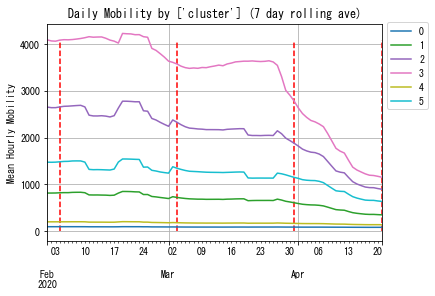

cluster,0,1,2,3,4,5
2020-03-03,-0.062486,-0.121640,-0.123379,-0.124938,-0.094899,-0.092649
2020-03-31,-0.091311,-0.259775,-0.292381,-0.318825,-0.169012,-0.224655
2020-04-21,-0.143725,-0.575415,-0.663016,-0.717933,-0.313175,-0.571773


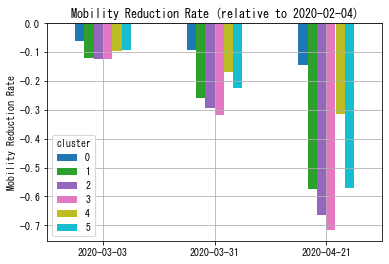

['gender'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
3       15  1                 51.833333            48.666667   
            2                 45.000000            53.833333   
        20  1                130.500000           129.333333   
            2                104.666667           258.166667   
        30  1                 51.500000            90.666667   
            2                 45.333333            76.500000   
        40  1                 64.333333            80.500000   
            2                 30.000000            80.666667   
        50  1                 55.166667            64.166667   
            2                 48.333333            59.000000   
        60  1                 15.333333            17.000000   
            2                 15.833333            23.833333   
        70  1                  5.666667            15.333333   
            2                  9.833333            11.333333   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
3       15  1                 39.333333            36.166667   
            2                 31.666667            26.833333   
        20  1                109.333333           136.500000   
            2                 91.833333           112.500000   
        30  1                 61.166667            95.000000   
            2                 46.000000            53.000000   
        40  1                 36.500000            44.333333   
            2                 38.833333            27.500000   
        50  1                 28.000000            36.000000   
            2                 27.166667            29.500000   
        60  1                  3.166667            16.500000   
            2                  9.666667            12.500000   
        70  1                 11.000000             6.000000   
            2                 12.833333             8.666667   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
3       15  1                 52.833333            57.000000   
            2                 53.666667            75.000000   
        20  1                251.666667           256.833333   
            2                233.500000           246.333333   
        30  1                103.166667           142.833333   
            2                 71.500000            70.000000   
        40  1                 59.500000           140.166667   
            2                 42.833333            63.000000   
        50  1                 47.500000           133.166667   
            2                 29.166667            68.666667   
        60  1                 21.500000            85.000000   
            2                  7.166667            30.000000   
        70  1                  9.833333            22.000000   
            2                  7.833333            11.333333   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
3       15  1                 60.166667            31.166667   
            2                 88.666667            32.333333   
        20  1                270.833333           218.000000   
            2                298.333333           251.666667   
        30  1                273.166667           211.666667   
            2                207.500000           304.666667   
        40  1                293.166667           178.500000   
            2                226.666667           222.500000   
        50  1                208.166667            99.000000   
            2                173.833333           122.666667   
        60  1                 98.333333            44.500000   
            2                 58.833333            56.833333   
        70  1                 17.666667          

Groupby ['gender']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
gender,,,,,,,,,,,,,,,,,,,,,
1,374.333333,445.666667,288.5,370.5,546.000000,837.000000,1221.500000,802.500000,490.333333,596.333333,...,139.833333,203.333333,206.000000,469.000000,742.333333,1536.666667,1950.166667,1411.166667,897.666667,562.366667
2,299.000000,563.333333,258.0,270.5,445.666667,564.333333,1068.666667,1017.166667,620.333333,998.833333,...,179.000000,231.166667,257.666667,418.666667,733.333333,1846.666667,1703.166667,862.833333,346.500000,165.566667


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
gender,,,,,,,,,,,,,,,,,,,,,
1,1895.692460,1888.603175,1887.525794,1895.670635,1900.632937,1899.719246,1903.778770,1907.376984,1906.718254,1906.248016,...,846.200000,783.965476,724.564881,694.396230,673.111905,653.257440,638.016071,635.644643,626.545933,615.879762
2,2195.757143,2180.062698,2175.618056,2190.166667,2194.546627,2192.966270,2194.344246,2201.314484,2214.272817,2231.419643,...,824.117361,731.829266,644.524901,613.083829,592.497917,571.684425,558.031944,554.052183,545.737798,536.598710


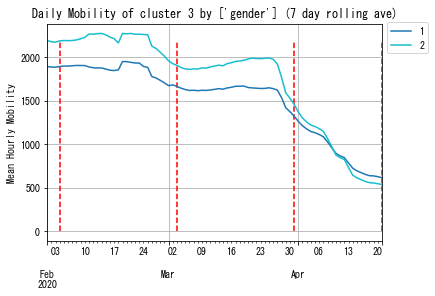

gender,1,2
2020-03-03,-0.120559,-0.128728
2020-03-31,-0.301519,-0.333803
2020-04-21,-0.675112,-0.754996


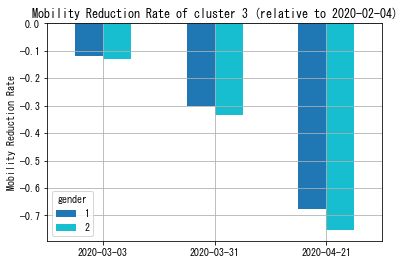

['age'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
3       15  1                 51.833333            48.666667   
            2                 45.000000            53.833333   
        20  1                130.500000           129.333333   
            2                104.666667           258.166667   
        30  1                 51.500000            90.666667   
            2                 45.333333            76.500000   
        40  1                 64.333333            80.500000   
            2                 30.000000            80.666667   
        50  1                 55.166667            64.166667   
            2                 48.333333            59.000000   
        60  1                 15.333333            17.000000   
            2                 15.833333            23.833333   
        70  1                  5.666667            15.333333   
            2                  9.833333            11.333333   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
3       15  1                 39.333333            36.166667   
            2                 31.666667            26.833333   
        20  1                109.333333           136.500000   
            2                 91.833333           112.500000   
        30  1                 61.166667            95.000000   
            2                 46.000000            53.000000   
        40  1                 36.500000            44.333333   
            2                 38.833333            27.500000   
        50  1                 28.000000            36.000000   
            2                 27.166667            29.500000   
        60  1                  3.166667            16.500000   
            2                  9.666667            12.500000   
        70  1                 11.000000             6.000000   
            2                 12.833333             8.666667   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
3       15  1                 52.833333            57.000000   
            2                 53.666667            75.000000   
        20  1                251.666667           256.833333   
            2                233.500000           246.333333   
        30  1                103.166667           142.833333   
            2                 71.500000            70.000000   
        40  1                 59.500000           140.166667   
            2                 42.833333            63.000000   
        50  1                 47.500000           133.166667   
            2                 29.166667            68.666667   
        60  1                 21.500000            85.000000   
            2                  7.166667            30.000000   
        70  1                  9.833333            22.000000   
            2                  7.833333            11.333333   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
3       15  1                 60.166667            31.166667   
            2                 88.666667            32.333333   
        20  1                270.833333           218.000000   
            2                298.333333           251.666667   
        30  1                273.166667           211.666667   
            2                207.500000           304.666667   
        40  1                293.166667           178.500000   
            2                226.666667           222.500000   
        50  1                208.166667            99.000000   
            2                173.833333           122.666667   
        60  1                 98.333333            44.500000   
            2                 58.833333            56.833333   
        70  1                 17.666667          

Groupby ['age']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
age,,,,,,,,,,,,,,,,,,,,,
15,96.833333,102.500000,71.000000,63.000000,106.500000,132.000000,148.833333,63.500000,55.166667,89.000000,...,24.166667,38.333333,30.666667,40.166667,114.666667,96.833333,64.000000,62.166667,24.666667,16.600000
20,235.166667,387.500000,201.166667,249.000000,485.166667,503.166667,569.166667,469.666667,242.500000,276.666667,...,61.833333,70.000000,92.333333,190.833333,232.000000,772.333333,1074.500000,738.666667,437.833333,262.166667
30,96.833333,167.166667,107.166667,148.000000,174.666667,212.833333,480.666667,516.333333,253.000000,272.833333,...,73.000000,98.333333,75.833333,164.500000,225.166667,681.666667,902.500000,583.666667,335.666667,228.500000
40,94.333333,161.166667,75.333333,71.833333,102.333333,203.166667,519.833333,401.000000,184.833333,301.000000,...,60.500000,61.666667,97.833333,139.666667,297.333333,689.500000,781.166667,475.666667,252.500000,136.166667
50,103.500000,123.166667,55.166667,65.500000,76.666667,201.833333,382.000000,221.666667,119.500000,277.000000,...,37.166667,39.666667,60.666667,151.833333,244.333333,699.000000,620.166667,309.666667,149.500000,55.166667
60,31.166667,40.833333,12.833333,29.000000,28.666667,115.000000,157.166667,101.333333,129.166667,214.166667,...,37.500000,61.000000,45.666667,129.000000,258.166667,363.666667,172.833333,81.833333,34.833333,22.000000
70,15.500000,26.666667,23.833333,14.666667,17.666667,33.333333,32.500000,46.166667,126.500000,164.500000,...,24.666667,65.500000,60.666667,71.666667,104.000000,80.333333,38.166667,22.333333,9.166667,7.333333


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
age,,,,,,,,,,,,,,,,,,,,,
15,287.454563,289.217460,291.550595,292.623016,297.337302,299.549603,302.309524,305.683532,306.794643,309.693452,...,62.270734,55.139583,50.593353,49.273313,48.106448,46.657738,45.023810,44.298611,43.691468,42.494345
20,1286.439484,1275.311508,1272.700397,1279.891865,1282.302579,1283.617063,1287.651786,1291.380952,1296.851190,1306.459325,...,475.810516,427.160119,380.829762,362.223611,349.724603,337.401190,328.229563,325.584722,320.223214,314.228175
30,819.749008,813.031746,810.554563,814.600198,814.808532,813.965278,813.949405,814.877976,818.587302,819.666667,...,377.657738,345.190476,312.840278,297.515873,287.934524,278.779762,272.532738,271.111111,266.953373,262.745040
40,686.798611,684.583333,684.034722,686.920635,688.305556,687.950397,687.982143,688.973214,691.037698,691.184524,...,319.234127,292.456349,265.723214,252.995040,244.650794,236.735119,231.625000,230.822421,227.360119,223.595238
50,565.853175,564.319444,563.785714,565.459325,566.802579,565.690476,566.034722,567.916667,568.504960,570.752976,...,251.944444,229.193452,206.876984,197.613095,190.881944,184.371032,180.742063,180.054563,177.287698,174.023810
60,289.477183,287.524802,286.293651,288.440476,288.157738,286.786706,286.053571,286.255952,286.386905,286.734127,...,128.568452,117.037698,106.380952,102.678571,99.684524,97.123016,95.165675,94.909722,93.833333,92.819444
70,155.677579,154.677579,154.224206,157.901786,157.465278,155.125992,154.141865,153.603175,152.828373,153.176587,...,54.831349,49.617063,45.845238,45.180556,44.626984,43.874008,42.729167,42.915675,42.934524,42.572421


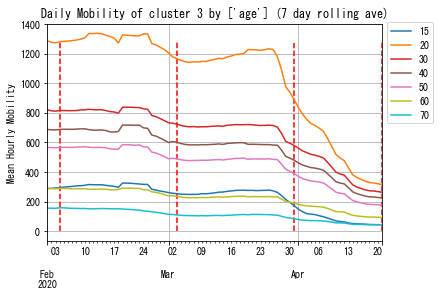

age,15,20,30,40,50,60,70
2020-03-03,-0.134676,-0.089320,-0.112570,-0.125986,-0.135809,-0.185356,-0.305538
2020-03-31,-0.410380,-0.304681,-0.289564,-0.302484,-0.312264,-0.342960,-0.465234
2020-04-21,-0.854781,-0.754488,-0.677455,-0.674496,-0.692243,-0.678202,-0.730387


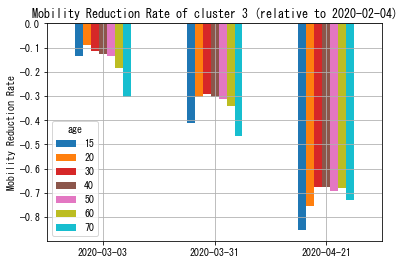

['gender'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
2       15  1                 51.764706            18.352941   
            2                 36.000000            27.882353   
        20  1                138.058824            85.941176   
            2                108.176471            97.529412   
        30  1                 61.647059            52.000000   
            2                 28.352941            46.764706   
        40  1                 47.117647            35.235294   
            2                 29.411765            22.529412   
        50  1                 39.117647            20.647059   
            2                 26.647059            21.000000   
        60  1                 15.882353            10.705882   
            2                 11.294118             9.176471   
        70  1                  5.058824             4.823529   
            2                  7.000000             5.470588   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
2       15  1                 11.117647            15.941176   
            2                 12.588235            12.470588   
        20  1                 39.764706            35.823529   
            2                 41.000000            39.882353   
        30  1                 23.294118            27.705882   
            2                 21.823529            22.588235   
        40  1                 20.176471            20.647059   
            2                 18.411765            17.705882   
        50  1                 16.000000            22.117647   
            2                 15.176471            20.588235   
        60  1                 11.176471             9.588235   
            2                  7.000000            11.470588   
        70  1                  5.117647             4.588235   
            2                  6.411765             6.470588   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
2       15  1                 14.470588            32.647059   
            2                 27.058824            35.882353   
        20  1                 67.529412            99.882353   
            2                 78.764706           110.058824   
        30  1                 49.058824            60.882353   
            2                 37.176471            34.235294   
        40  1                 42.529412           119.588235   
            2                 40.117647            30.941176   
        50  1                 27.529412           152.647059   
            2                 26.470588            36.764706   
        60  1                 18.352941            78.764706   
            2                 13.823529            25.294118   
        70  1                  9.882353            23.058824   
            2                 12.117647            10.823529   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
2       15  1                 32.529412            26.411765   
            2                 42.941176            23.529412   
        20  1                203.000000           316.176471   
            2                176.000000           355.647059   
        30  1                319.588235           480.411765   
            2                173.352941           416.764706   
        40  1                383.941176           384.941176   
            2                200.000000           398.705882   
        50  1                332.588235           216.470588   
            2                162.117647           239.941176   
        60  1                140.352941            85.470588   
            2                 49.470588            63.764706   
        70  1                 19.882353          

Groupby ['gender']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
gender,,,,,,,,,,,,,,,,,,,,,
1,358.647059,227.705882,126.647059,136.411765,229.352941,567.470588,1431.882353,1533.470588,499.705882,816.764706,...,125.235294,187.647059,233.941176,478.882353,1099.117647,1653.647059,1457.000000,1042.058824,583.227941,321.750000
2,246.882353,230.352941,122.411765,131.176471,235.529412,284.000000,819.000000,1517.470588,703.235294,589.705882,...,100.411765,172.470588,238.176471,544.470588,1010.705882,1221.176471,874.742081,490.042421,184.552614,76.455042


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
gender,,,,,,,,,,,,,,,,,,,,,
1,1412.901424,1408.095314,1410.242012,1416.912202,1424.692380,1427.294840,1432.044380,1432.014618,1432.813769,1408.665682,...,711.574342,661.883426,616.644762,589.991149,570.972401,554.138412,546.943068,546.052264,535.832978,526.831970
2,1240.325114,1232.805823,1231.008431,1239.780626,1245.198692,1246.061828,1247.539887,1254.141340,1258.318817,1248.499933,...,535.113721,486.631218,441.005417,418.767899,403.268018,388.930341,383.787906,382.928451,374.751668,368.432096


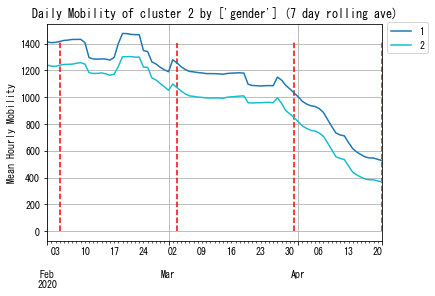

gender,1,2
2020-03-03,-0.112851,-0.135411
2020-03-31,-0.271713,-0.316002
2020-04-21,-0.628183,-0.702825


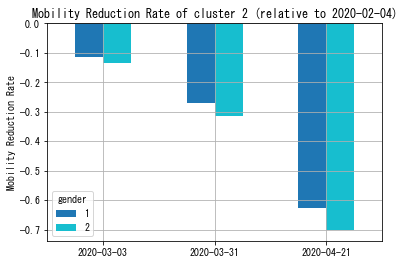

['age'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster age gender                                             
2       15  1                 51.764706            18.352941   
            2                 36.000000            27.882353   
        20  1                138.058824            85.941176   
            2                108.176471            97.529412   
        30  1                 61.647059            52.000000   
            2                 28.352941            46.764706   
        40  1                 47.117647            35.235294   
            2                 29.411765            22.529412   
        50  1                 39.117647            20.647059   
            2                 26.647059            21.000000   
        60  1                 15.882353            10.705882   
            2                 11.294118             9.176471   
        70  1                  5.058824             4.823529   
            2                  7.000000             5.470588   

                    2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster age gender                                             
2       15  1                 11.117647            15.941176   
            2                 12.588235            12.470588   
        20  1                 39.764706            35.823529   
            2                 41.000000            39.882353   
        30  1                 23.294118            27.705882   
            2                 21.823529            22.588235   
        40  1                 20.176471            20.647059   
            2                 18.411765            17.705882   
        50  1                 16.000000            22.117647   
            2                 15.176471            20.588235   
        60  1                 11.176471             9.588235   
            2                  7.000000            11.470588   
        70  1                  5.117647             4.588235   
            2                  6.411765             6.470588   

                    2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster age gender                                             
2       15  1                 14.470588            32.647059   
            2                 27.058824            35.882353   
        20  1                 67.529412            99.882353   
            2                 78.764706           110.058824   
        30  1                 49.058824            60.882353   
            2                 37.176471            34.235294   
        40  1                 42.529412           119.588235   
            2                 40.117647            30.941176   
        50  1                 27.529412           152.647059   
            2                 26.470588            36.764706   
        60  1                 18.352941            78.764706   
            2                 13.823529            25.294118   
        70  1                  9.882353            23.058824   
            2                 12.117647            10.823529   

                    2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster age gender                                             
2       15  1                 32.529412            26.411765   
            2                 42.941176            23.529412   
        20  1                203.000000           316.176471   
            2                176.000000           355.647059   
        30  1                319.588235           480.411765   
            2                173.352941           416.764706   
        40  1                383.941176           384.941176   
            2                200.000000           398.705882   
        50  1                332.588235           216.470588   
            2                162.117647           239.941176   
        60  1                140.352941            85.470588   
            2                 49.470588            63.764706   
        70  1                 19.882353          

Groupby ['age']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
age,,,,,,,,,,,,,,,,,,,,,
15,87.764706,46.235294,23.705882,28.411765,41.529412,68.529412,75.470588,49.941176,48.764706,55.235294,...,16.647059,14.764706,16.529412,23.588235,40.823529,36.764706,28.742081,25.167421,23.763889,11.350000
20,246.235294,183.470588,80.764706,75.705882,146.294118,209.941176,379.000000,671.823529,279.647059,304.764706,...,41.823529,48.764706,59.058824,130.588235,302.352941,595.588235,545.235294,365.705882,180.705882,96.823529
30,90.000000,98.764706,45.117647,50.294118,86.235294,95.117647,492.941176,897.176471,303.352941,365.764706,...,49.941176,61.529412,89.470588,194.470588,404.411765,625.411765,587.294118,402.882353,213.235294,126.647059
40,76.529412,57.764706,38.588235,38.352941,82.647059,150.529412,583.941176,783.647059,246.352941,316.470588,...,40.764706,71.352941,106.941176,227.058824,476.176471,682.000000,580.764706,395.764706,212.647059,103.268382
50,65.764706,41.647059,31.176471,42.705882,54.000000,189.411765,494.705882,456.411765,169.117647,213.058824,...,33.058824,65.470588,77.176471,227.470588,498.294118,633.588235,446.529412,257.705882,106.352941,37.363971
60,27.176471,19.882353,18.176471,21.058824,32.176471,104.058824,189.823529,149.235294,84.235294,77.941176,...,26.764706,59.117647,73.235294,160.294118,307.235294,252.000000,111.705882,66.058824,23.044118,13.710084
70,12.058824,10.294118,11.529412,11.058824,22.000000,33.882353,35.000000,42.705882,71.470588,73.235294,...,16.647059,39.117647,49.705882,59.882353,80.529412,49.470588,31.470588,18.816176,8.031373,9.042017


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
age,,,,,,,,,,,,,,,,,,,,,
15,100.230586,98.772438,100.335003,101.320148,102.947073,104.156016,105.421824,104.675807,104.787983,104.728049,...,27.474853,25.252683,23.735432,23.132137,22.776283,22.320083,21.799584,21.680539,21.288937,20.748907
20,622.227591,619.537465,620.396359,624.084034,627.449930,627.568978,628.848039,631.604692,632.059174,624.237745,...,264.369879,239.538981,217.493397,206.001604,198.341108,191.404685,188.650089,188.097242,183.693854,180.402397
30,603.699930,601.117647,601.138655,603.919818,606.091737,606.810224,607.033263,607.935924,609.173319,599.721989,...,290.837960,268.229580,246.106225,233.967245,225.690898,218.216933,215.319836,214.879147,210.501776,206.968631
40,571.853992,570.063375,569.472689,571.713585,574.113796,575.078431,576.814426,577.632003,578.961134,570.984244,...,288.485157,267.651285,247.683214,236.256213,227.881636,220.611914,217.937766,217.600434,213.203198,209.447115
50,455.063025,453.788515,453.876401,456.372899,458.795868,459.919818,460.620798,461.829482,462.604692,455.843487,...,233.201134,215.612024,199.076354,189.928122,183.268498,177.372650,175.353438,175.091590,171.550875,168.753340
60,212.562675,211.027311,209.854692,211.393207,212.215686,212.068277,212.659664,213.521709,213.935574,211.989846,...,105.999140,98.284333,91.296022,87.846131,85.285852,82.872090,81.919367,81.820411,80.702146,79.597371
70,87.588739,86.594385,86.176646,87.889137,88.276983,87.754924,88.186253,88.956342,89.610710,89.660255,...,36.319939,33.945757,32.259534,31.627596,30.996144,30.270399,29.750892,29.811353,29.643860,29.346305


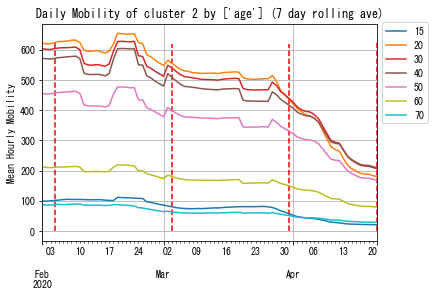

age,15,20,30,40,50,60,70
2020-03-03,-0.202469,-0.109884,-0.106897,-0.109772,-0.123853,-0.146016,-0.272884
2020-03-31,-0.431889,-0.302190,-0.273065,-0.271761,-0.276700,-0.290039,-0.415830
2020-04-21,-0.795214,-0.710933,-0.657291,-0.633650,-0.630229,-0.623463,-0.666099


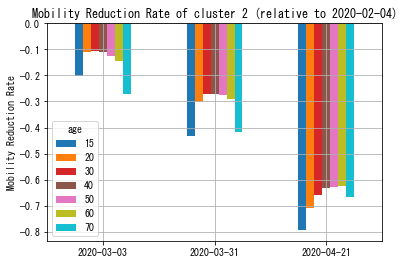

time: 4.74 s


In [38]:
%load_ext autotime


# Mobility Time Series by Category
window = 7

yesterday = pd.Timestamp.today().date()-pd.Timedelta('1 days')
print(str(yesterday))
reference_dates = pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31', str(yesterday)])

def plot_mobility_by_cat(df, cat, reference_dates, cluster=None, window=7, cmap=plt.get_cmap("tab10")):
    if cluster is not None:
        df = df[list(map(lambda x: x[0] == cluster, df.index))]   # Select specified cluster
    debug = True
    if debug:
        print(cat, reference_dates, window)
        display(df)
    mobility_by_cat = df.groupby(cat).sum()
    if debug:
        print("Groupby", cat)
        display(mobility_by_cat)
    mobility_by_cat = mobility_by_cat.resample('1D', axis=1).mean() \
                    .rolling(window, axis=1).mean() \
                    .loc[:, '2020-2-1':]
    if debug:
        print("Resampled")
        display(mobility_by_cat)
    if cluster is not None:
        title = "Daily Mobility of cluster {} by {} ({} day rolling ave)".format(cluster, cat, window)
    else:
        title = "Daily Mobility by {} ({} day rolling ave)".format(cat, window)
    maxy = mobility_by_cat.max()
    mobility_by_cat.T.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    plt.ylabel("Mean Hourly Mobility")
    plt.vlines(reference_dates, 0, maxy, "red", linestyles='dashed')
    plt.show()

    # mobility reduction rate by cluster
    m = mobility_by_cat.loc[:,reference_dates]
    for t in range(1, len(reference_dates)):
        m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0
    if debug:
        display(m.drop(columns=reference_dates[0]).T)
    m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
    if cluster is not None:
        plt.title("Mobility Reduction Rate of cluster {} (relative to {})".format(cluster, reference_dates[0].date()))
    else:
        plt.title("Mobility Reduction Rate (relative to {})".format(reference_dates[0].date()))
    plt.ylabel("Mobility Reduction Rate")
    plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
    plt.show()
    return


df = read_cache("00001_c")
df = df[list(map(lambda x: x[2] != 0, df.index))]   # Remove gender==0 records
df = df.iloc[:, 1:]   # Remove Jan. 1 because it has no mobility data
# display(df[list(map(lambda x: x[0] == 3, df.index))])

plot_mobility_by_cat(df,["gender"], reference_dates)
plot_mobility_by_cat(df,["age"], reference_dates)
plot_mobility_by_cat(df,["cluster"], reference_dates)

plot_mobility_by_cat(df,["gender"], reference_dates, cluster=3)
plot_mobility_by_cat(df,["age"], reference_dates, cluster=3)

plot_mobility_by_cat(df,["gender"], reference_dates, cluster=2)
plot_mobility_by_cat(df,["age"], reference_dates, cluster=2)


['residence'] DatetimeIndex(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-21'], dtype='datetime64[ns]', freq=None) 7


2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster residence                                             
0       1                    12.925373            12.460784   
        2                    12.700000            12.933333   
        3                    11.652174            12.857143   
        4                    12.347458            11.422018   
        5                    11.666667            12.300000   
...                                ...                  ...   
5       43                   10.384615            11.437500   
        44                   12.750000            12.000000   
        45                   13.000000            11.400000   
        46                   14.000000            10.750000   
        47                   10.181818            12.333333   

                   2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster residence                                             
0       1                    12.482587            12.657534   
        2                    12.466667            11.500000   
        3                    13.250000            11.958333   
        4                    12.119658            12.072581   
        5                    11.545455            11.944444   
...                                ...                  ...   
5       43                   12.466667            12.307692   
        44                   12.400000            12.750000   
        45                   13.000000            13.625000   
        46                   11.500000            11.600000   
        47                   10.346154            12.384615   

                   2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster residence                                             
0       1                    12.508929            12.383178   
        2                    12.370370            11.833333   
        3                    10.125000            11.652174   
        4                    12.521739            12.465753   
        5                    12.105263            12.181818   
...                                ...                  ...   
5       43                   13.454545            14.888889   
        44                   16.000000            14.500000   
        45                   12.400000            13.166667   
        46                   11.571429            10.142857   
        47                   11.370370            11.500000   

                   2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster residence                                             
0       1                    12.513274            12.718367   
        2                    11.464286            11.750000   
        3                    11.961538            12.966667   
        4                    12.012987            12.346154   
        5                    12.250000            11.142857   
...                                ...                  ...   
5       43                   14.384615             9.375000   
        44                   11.333333            13.500000   
        45                   13.500000            15.750000   
        46                   13.666667            13.142857   
        47                   12.851852            12.130435   

                   2020-01-01 09:00:00  2020-01-01 10:00:00  ...  \
cluster residence                                            ...   
0       1                    13.057778            12.714976  ...   
        2                    11.590909            11.363636  ...   
        3                    12.481481            11.416667  ...   
        4                    12.675159            12.368750  ...   
        5                    11.200000            11.526316  ...   
...                                ...                  ...  ...   
5       43                   15.555556            13.470588  ...   
        44                   10.500000            11.600000  ...   
        45                   14.833333            12.250000

Groupby ['residence']


,2020-01-01 01:00:00,2020-01-01 02:00:00,2020-01-01 03:00:00,2020-01-01 04:00:00,2020-01-01 05:00:00,2020-01-01 06:00:00,2020-01-01 07:00:00,2020-01-01 08:00:00,2020-01-01 09:00:00,2020-01-01 10:00:00,...,2020-04-21 14:00:00,2020-04-21 15:00:00,2020-04-21 16:00:00,2020-04-21 17:00:00,2020-04-21 18:00:00,2020-04-21 19:00:00,2020-04-21 20:00:00,2020-04-21 21:00:00,2020-04-21 22:00:00,2020-04-21 23:00:00
residence,,,,,,,,,,,,,,,,,,,,,
1,82.578513,84.211496,81.408550,70.115729,77.972444,72.015471,76.709878,80.071261,85.927876,82.738766,...,66.077094,74.867986,67.548531,67.494198,67.175490,65.008265,69.464957,67.278753,70.972708,61.490707
2,74.182239,72.207646,73.606349,78.666667,86.822751,78.372619,71.677318,84.872807,70.435270,77.284585,...,53.184815,63.646628,63.738782,66.519118,66.340523,46.262351,35.800000,46.535525,56.378788,58.166667
3,73.140061,84.411741,81.120635,84.465404,72.446899,80.552443,74.115679,71.730952,69.965194,67.883929,...,59.898162,56.340741,57.679545,48.558333,51.100000,33.878182,45.625000,38.170996,58.666667,42.965909
4,85.643117,73.903849,81.094055,74.117004,76.422385,70.035387,72.647868,79.867045,68.870319,65.906420,...,63.822429,70.912751,78.830952,80.605779,78.367974,73.057767,68.925852,76.986593,73.574655,65.238391
5,70.858277,67.686691,72.644621,73.740363,70.417269,73.252343,79.750000,72.545974,73.842105,77.143582,...,46.254762,46.079365,39.188312,43.142857,33.782051,33.750000,42.785714,43.464286,33.166667,33.033333
6,73.002101,73.981714,70.539719,83.255051,78.642075,67.475666,84.271344,70.778140,81.312128,72.634892,...,73.880952,60.154762,57.841026,47.321839,34.486607,35.692593,33.552632,36.367216,36.843750,35.578788
7,77.286895,83.877129,79.655444,80.185146,84.326733,81.885595,80.695342,76.854192,72.931051,71.281445,...,61.741120,58.161589,68.824842,74.331481,63.258795,57.941077,67.801255,69.516667,66.081502,60.706897
8,89.952454,97.378996,85.095068,90.554927,79.136357,85.410169,121.880332,111.422648,80.394342,99.761945,...,77.362257,74.375800,80.356356,91.651155,95.230644,98.901066,93.097667,72.010408,60.043324,75.228694
9,84.215123,89.865985,72.289717,79.308620,77.000652,75.439339,85.976127,76.366083,60.519346,69.308162,...,60.828736,60.974023,65.743034,63.988660,69.030613,72.099543,77.509644,69.704119,53.246970,56.645789


Resampled


,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,...,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21
residence,,,,,,,,,,,,,,,,,,,,,
1,85.352641,85.306345,85.111512,85.204900,85.857019,86.523988,87.387155,88.568885,89.144788,90.014876,...,70.478466,69.934030,70.016077,69.660345,69.723583,69.386050,69.232441,69.733988,70.011276,69.869094
2,73.655196,73.172747,73.311095,72.806239,72.686661,73.070189,73.114490,73.274381,73.537536,73.551407,...,55.341850,53.771541,52.434029,51.938837,50.213559,49.886157,49.699804,49.184157,48.868982,49.196822
3,73.938129,73.696078,73.369076,73.193426,73.801024,73.573141,73.702684,73.590571,73.608765,73.706974,...,54.960009,54.503884,53.009243,51.866126,50.649677,49.814032,49.112412,48.919871,47.703730,47.357134
4,80.480581,79.738308,79.734152,79.859334,80.685167,81.154369,81.804560,81.613729,82.389423,82.501113,...,69.593094,68.989860,68.752769,68.541872,68.158587,68.321019,68.314546,68.244499,68.066785,68.625837
5,71.646350,71.423012,72.321105,72.688763,72.964919,73.031631,73.157328,73.094871,72.935837,73.070309,...,43.847283,42.325068,41.966096,41.532797,40.683413,40.985313,41.204033,40.581996,39.056942,38.326457
6,72.625553,72.531060,72.812175,73.095437,72.773918,72.430129,72.250285,72.335050,72.367239,71.927065,...,52.067125,50.724597,49.426318,48.490934,46.821933,45.216706,44.966668,44.638795,43.704990,43.383840
7,78.980693,78.429282,78.948729,79.104301,79.389674,79.682011,80.105249,80.056955,80.223824,80.050245,...,64.263493,63.653165,63.256962,63.017520,63.135130,62.482704,62.501978,62.589099,62.620323,62.154583
8,140.658574,139.957708,140.338697,140.539199,141.173788,141.745798,142.359621,143.985657,143.987490,143.250026,...,87.288772,84.709054,82.536168,81.441580,80.973515,80.327044,79.921942,79.820003,79.607847,79.157941
9,93.582248,93.141059,93.203334,93.411655,93.951713,93.869564,94.448934,94.848042,95.258016,95.427724,...,67.299495,66.155045,64.888463,64.515863,64.210842,64.038870,63.725476,63.307799,63.529419,63.747936


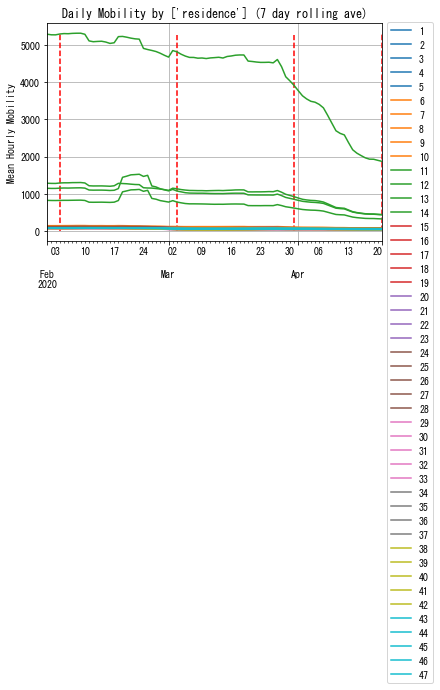

residence,1,2,3,4,5,6,7,8,9,10,...,38,39,40,41,42,43,44,45,46,47
2020-03-03,-0.137044,-0.087731,-0.107556,-0.097943,-0.234607,-0.111206,-0.118835,-0.168658,-0.149705,-0.162534,...,-0.171646,-0.454706,-0.143323,-0.401870,-0.224878,-0.189494,-0.276850,-0.267699,-0.076552,-0.045508
2020-03-31,-0.146485,-0.098884,-0.170926,-0.104567,-0.223164,-0.137405,-0.103453,-0.262285,-0.206958,-0.211491,...,-0.208476,-0.398991,-0.148189,-0.400301,-0.232315,-0.167690,-0.341862,-0.255692,-0.159683,-0.045032
2020-04-21,-0.179987,-0.324277,-0.352987,-0.140666,-0.472732,-0.406477,-0.214271,-0.436755,-0.317559,-0.285080,...,-0.414031,-0.548558,-0.166553,-0.481177,-0.364202,-0.370846,-0.493192,-0.375627,-0.320419,-0.262533


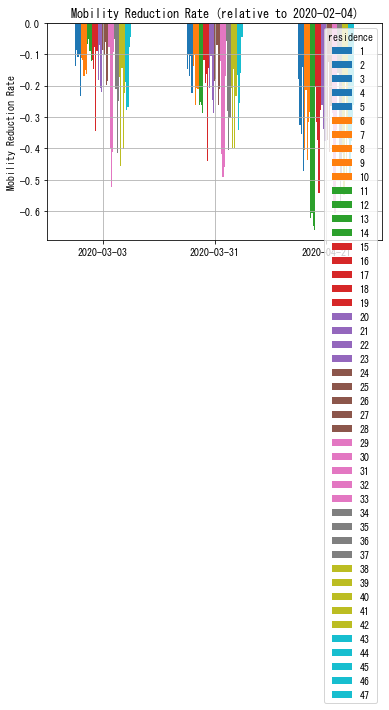

2020-01-01 01:00:00  2020-01-01 02:00:00  \
cluster residence                                             
0       1                    12.925373            12.460784   
        2                    12.700000            12.933333   
        3                    11.652174            12.857143   
        4                    12.347458            11.422018   
        5                    11.666667            12.300000   
...                                ...                  ...   
5       43                   10.384615            11.437500   
        44                   12.750000            12.000000   
        45                   13.000000            11.400000   
        46                   14.000000            10.750000   
        47                   10.181818            12.333333   

                   2020-01-01 03:00:00  2020-01-01 04:00:00  \
cluster residence                                             
0       1                    12.482587            12.657534   
        2                    12.466667            11.500000   
        3                    13.250000            11.958333   
        4                    12.119658            12.072581   
        5                    11.545455            11.944444   
...                                ...                  ...   
5       43                   12.466667            12.307692   
        44                   12.400000            12.750000   
        45                   13.000000            13.625000   
        46                   11.500000            11.600000   
        47                   10.346154            12.384615   

                   2020-01-01 05:00:00  2020-01-01 06:00:00  \
cluster residence                                             
0       1                    12.508929            12.383178   
        2                    12.370370            11.833333   
        3                    10.125000            11.652174   
        4                    12.521739            12.465753   
        5                    12.105263            12.181818   
...                                ...                  ...   
5       43                   13.454545            14.888889   
        44                   16.000000            14.500000   
        45                   12.400000            13.166667   
        46                   11.571429            10.142857   
        47                   11.370370            11.500000   

                   2020-01-01 07:00:00  2020-01-01 08:00:00  \
cluster residence                                             
0       1                    12.513274            12.718367   
        2                    11.464286            11.750000   
        3                    11.961538            12.966667   
        4                    12.012987            12.346154   
        5                    12.250000            11.142857   
...                                ...                  ...   
5       43                   14.384615             9.375000   
        44                   11.333333            13.500000   
        45                   13.500000            15.750000   
        46                   13.666667            13.142857   
        47                   12.851852            12.130435   

                   2020-01-01 09:00:00  2020-01-01 10:00:00  ...  \
cluster residence                                            ...   
0       1                    13.057778            12.714976  ...   
        2                    11.590909            11.363636  ...   
        3                    12.481481            11.416667  ...   
        4                    12.675159            12.368750  ...   
        5                    11.200000            11.526316  ...   
...                                ...                  ...  ...   
5       43                   15.555556            13.470588  ...   
        44                   10.500000            11.600000  ...   
        45                   14.833333            12.250000

time: 1.71 s


In [39]:
# Try 00002_c, the residence prefecture


df = read_cache("00002_c")
df = df[list(map(lambda x: x[1] != 0, df.index))]   # Remove residence==0 records
df = df.iloc[:, 1:]   # Remove Jan. 1 because it has no mobility data
plot_mobility_by_cat(df,["residence"], reference_dates)
df

In [6]:
# Load the row-based data and convert them into a time_pop_table
# Only new data up until yesterday will be processed and appended to the table file
# How to download files from S3
# $ aws s3 sync s3://mobaku-delivery-user002 .
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
%load_ext autotime

def read_time_pop_table(year):
    t = pd.read_csv(cache_dir + year + "_out2.csv", parse_dates=[0]) \
        .rename(columns={"Unnamed: 0": "Date_Time"}) \
        .set_index("Date_Time")
    return t

year = "2020"
time_pop_table_t = read_time_pop_table(year).T
# display(time_pop_table_t.head())
# print(time_pop_table_t.index)

last_date = time_pop_table_t.columns[-1]
print("last_date = ", last_date)
print(pd.Timestamp.today())
dates_to_add = pd.date_range(start=last_date.date()+pd.Timedelta('1 days'), end=pd.Timestamp.today()-pd.Timedelta('1 days'))
print(dates_to_add)

for d in dates_to_add:
    d_str = d.strftime("%Y%m%d")
    for h in range(24):
        f = data_dir + "s3/realtime/{}/clipped_mesh_pop_{}{:02d}00_00000.csv.zip".format(d_str,d_str,h)
        print("Reading {}...".format(f))
        hourly = pd.read_csv(f,usecols=["area", "population"], dtype={"area": str})
        hourly = hourly.set_index("area")
        d_h = d + pd.Timedelta('{} hours'.format(h))
        hourly.rename(columns={"population": d_h}, inplace=True)
        # print(d_h)
        # display(hourly.head())
        # print(hourly.index)
        time_pop_table_t = time_pop_table_t.merge(hourly, how='left', left_index=True, right_index=True)
    
time_pop_table_t.T.to_csv(cache_dir + year + "_out2.csv")


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
last_date =  2020-04-19 23:00:00
2020-04-22 17:23:36.010758
DatetimeIndex(['2020-04-20', '2020-04-21'], dtype='datetime64[ns]', freq='D')
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200000_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200100_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200200_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200300_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200400_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200500_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200420/clipped_mesh_pop_202004200600_00000.csv.zip...
Reading f:/Users/Hiros

In [7]:
# Load the row-based data and convert them into a table

import pandas as pd
import matplotlib.pyplot as plt
import os
%load_ext autotime

year = "2020"
year = "2019"

def convert_to_table(year):
    fn = "data/DoCoMo/" + year + "_all.csv"
    if os.path.exists(fn):
        pass
    else:
        d = pd.read_csv(fn,usecols=[0,1,2,6],names=["Date", "Time", "Mesh", "Population"],
                        # dtype={"Mesh":str},
                        parse_dates=[[0,1]],header=None)

        print("{} loaded, n_records={}".format(fn, len(d)))
        start_time, end_time = d["Date_Time"].min(), d["Date_Time"].max()
        time_range = pd.date_range(start=start_time, end=end_time, freq='H')
        print("time_range=", time_range)
        mesh_list = d["Mesh"].unique()
        print("n_mesh=", len(mesh_list))
        print("mesh_list=", mesh_list)
        df = pd.DataFrame(index=time_range, columns=mesh_list)

        for i, row in d.iterrows():
            if i % 100000 == 0:
                print("{}: Processing record {}...".format(pd.Timestamp.now(), i))
            date_time = row[0]
            mesh = row[1]
            population = row[2]
            df.loc[date_time, mesh] = population

        df.to_csv("Data/DoCoMo/" + year + "_out2.csv")

# convert_to_table("2019")
# convert_to_table("2020")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.99 ms


In [9]:
# Load table data into DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autotime
default_figsize = plt.rcParams['figure.figsize']

def read_out2(year):
    df = pd.read_csv(cache_dir + year + "_out2.csv", parse_dates=[0])
    df = df.rename(columns={'Unnamed: 0':"Date_Time"}).set_index("Date_Time").fillna(0)
    l1_delta = np.zeros(len(df))
    l2_delta = np.zeros(len(df))
    mean = np.zeros(len(df))
    std = np.zeros(len(df))
    for i in range(1,len(df)):
        l1_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=1)
        l2_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=2)
        mean[i] = df.iloc[i].mean()
        std[i] = df.iloc[i].std()
    df["L1"] = l1_delta
    df["L2"] = l2_delta
    df["mean"] = mean
    df["std"] = std
    return df

mobility_2019 = read_out2("2019")
mobility_2020 = read_out2("2020")



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 1min 27s


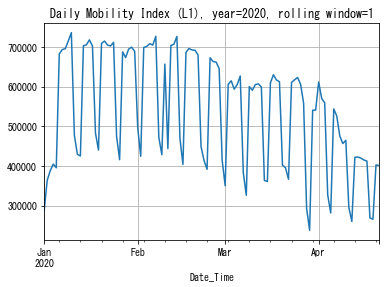

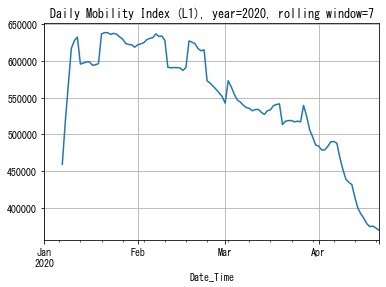

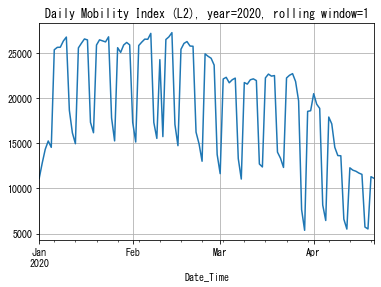

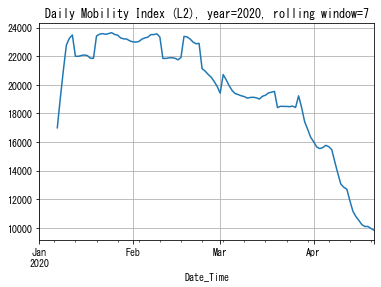

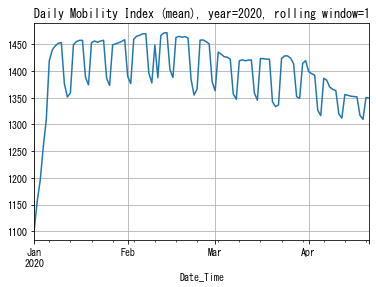

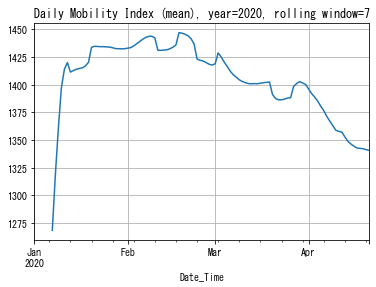

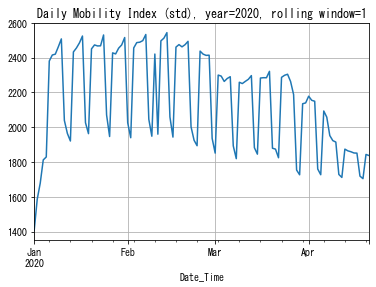

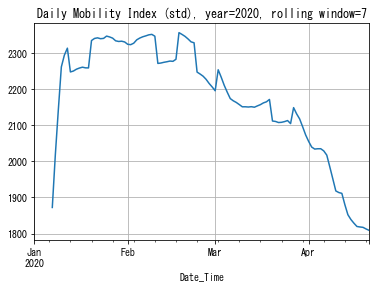

time: 1.39 s


In [10]:
# plot various mobility indicators 

def mobility_plot(df, metric, year, w):
    mobility = df[metric]
    daily_mobility = mobility.resample('1D').mean().rolling(w).mean()
    plt.title("Daily Mobility Index ({}), year={}, rolling window={}".format(metric, year,w))
    daily_mobility.plot(grid=True)
    plt.show()


# mobility_plot(mobility_2020.loc[pd.to_datetime("2020-02-01"):], "L1", "2020", 7)
    
#mobility_plot(mobility_2019, "L1", "2019", 1)
#mobility_plot(mobility_2019, "L1", "2019", 7)
mobility_plot(mobility_2020, "L1", "2020", 1)
mobility_plot(mobility_2020, "L1", "2020", 7)

#mobility_plot(mobility_2019, "L2", "2019", 1)
#mobility_plot(mobility_2019, "L2", "2019", 7)
mobility_plot(mobility_2020, "L2", "2020", 1)
mobility_plot(mobility_2020, "L2", "2020", 7)

#mobility_plot(mobility_2019, "mean", "2019", 1)
#mobility_plot(mobility_2019, "mean", "2019", 7)
mobility_plot(mobility_2020, "mean", "2020", 1)
mobility_plot(mobility_2020, "mean", "2020", 7)

#mobility_plot(mobility_2019, "std", "2019", 1)
#mobility_plot(mobility_2019, "std", "2019", 7)
mobility_plot(mobility_2020, "std", "2020", 1)
mobility_plot(mobility_2020, "std", "2020", 7)



## Confirmed Cases in Tokyo
- Data source: [Tokyo Metropolitan Governmnet Open Data Catalogue Site](https://portal.data.metro.tokyo.lg.jp/) [Dashboard](https://stopcovid19.metro.tokyo.lg.jp/)

Days in daily_confirmed_cases= 52


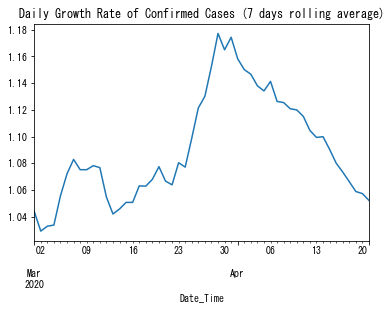

time: 959 ms


In [11]:
# Load confirmed cases

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

daily_confirmed_cases = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv',
                    usecols=["公表_年月日", "患者_年代", "患者_性別"],
                    parse_dates=["公表_年月日"]) \
    .groupby("公表_年月日") \
    .count().drop(columns=["患者_年代"]) \
    .reset_index() \
    .rename(columns={"患者_性別": "Confirmed_Cases", "公表_年月日": "Date_Time"}) \
    .set_index("Date_Time")

daily_confirmed_cases = daily_confirmed_cases.asfreq('1D', fill_value=0)

# display(daily_confirmed_cases.asfreq('1D', fill_value=0))

window = 7
# plt.grid()
daily_confirmed_cases["Cumulative"] = daily_confirmed_cases["Confirmed_Cases"].cumsum()
daily_confirmed_cases["GrowthRate"] = daily_confirmed_cases["Cumulative"].pct_change().rolling(window).mean()
daily_confirmed_cases = daily_confirmed_cases["2020-03-01":]
days = len(daily_confirmed_cases)
print("Days in daily_confirmed_cases=", len(daily_confirmed_cases))

plt.title("Daily Growth Rate of Confirmed Cases ({} days rolling average)".format(window)) 
(daily_confirmed_cases["GrowthRate"] + 1.0).plot()

last date in mobility = 2020-04-21 00:00:00
last date confirmed = 2020-04-21 00:00:00
first date confirmed = 2020-03-01 00:00:00
min_delay =  0
days in confirmed_cases = 51 days 00:00:00
0 2020-03-01 00:00:00 2020-04-21 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


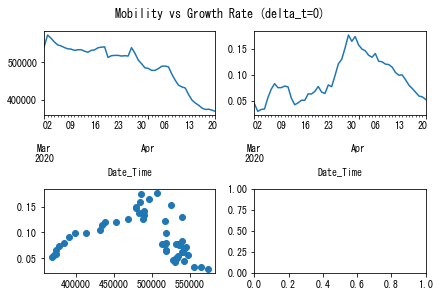

1 2020-02-29 00:00:00 2020-04-20 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


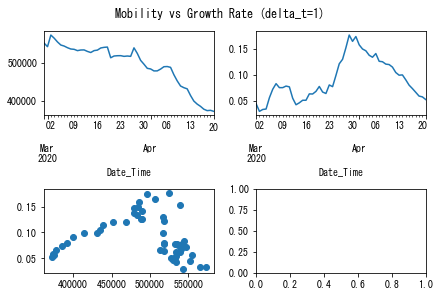

2 2020-02-28 00:00:00 2020-04-19 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


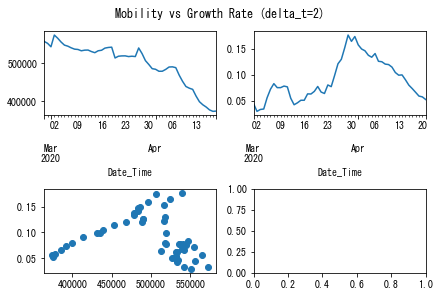

3 2020-02-27 00:00:00 2020-04-18 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


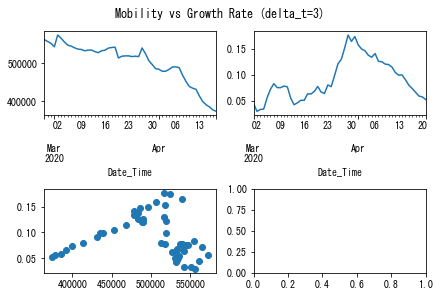

4 2020-02-26 00:00:00 2020-04-17 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


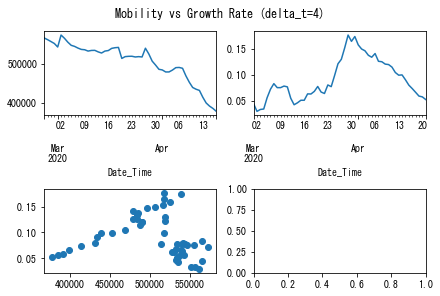

5 2020-02-25 00:00:00 2020-04-16 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


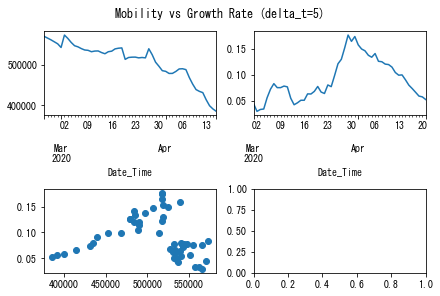

6 2020-02-24 00:00:00 2020-04-15 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


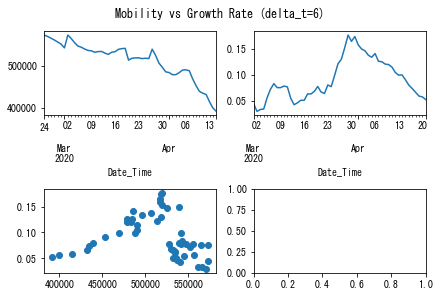

7 2020-02-23 00:00:00 2020-04-14 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


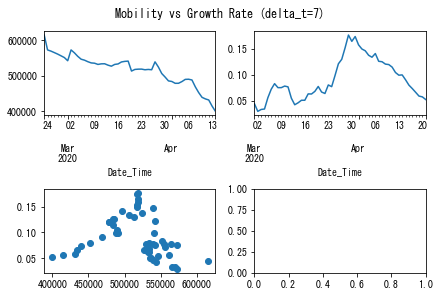

8 2020-02-22 00:00:00 2020-04-13 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


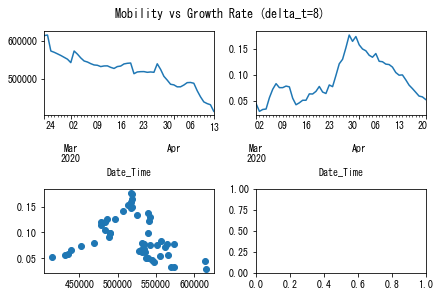

9 2020-02-21 00:00:00 2020-04-12 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


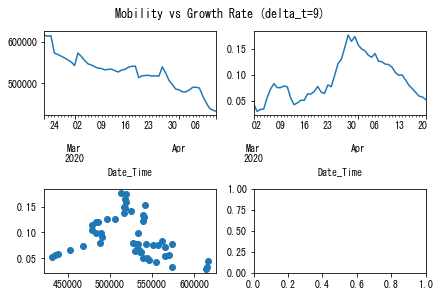

10 2020-02-20 00:00:00 2020-04-11 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


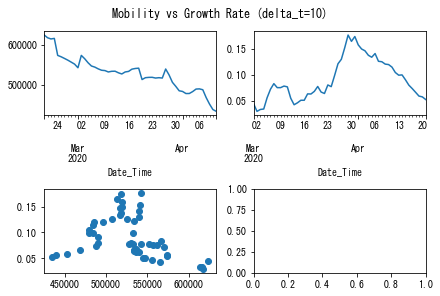

11 2020-02-19 00:00:00 2020-04-10 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


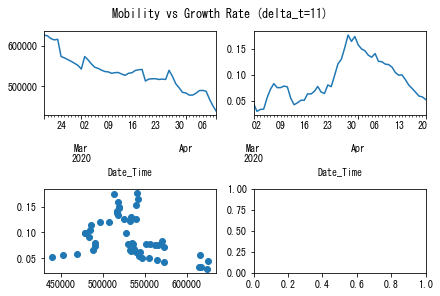

12 2020-02-18 00:00:00 2020-04-09 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


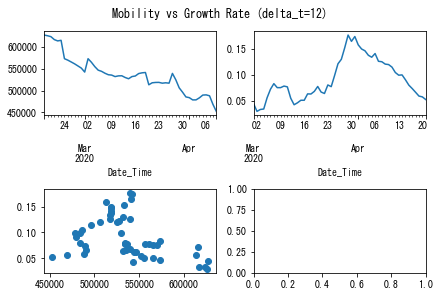

13 2020-02-17 00:00:00 2020-04-08 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


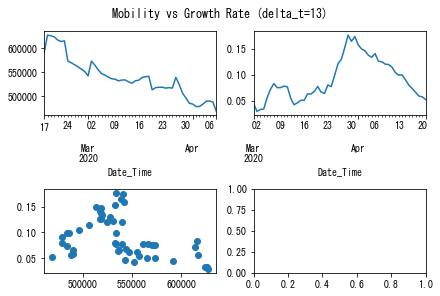

14 2020-02-16 00:00:00 2020-04-07 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


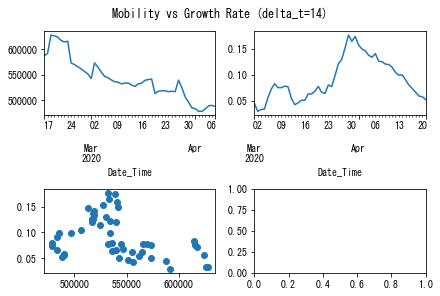

15 2020-02-15 00:00:00 2020-04-06 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


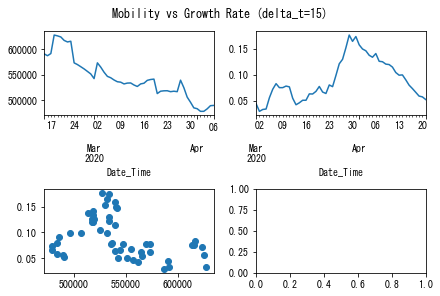

16 2020-02-14 00:00:00 2020-04-05 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


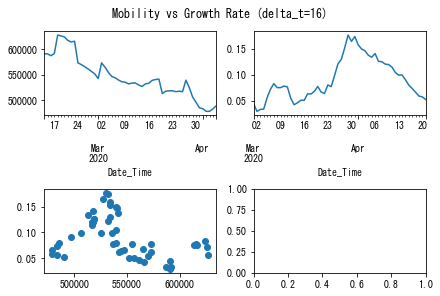

17 2020-02-13 00:00:00 2020-04-04 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


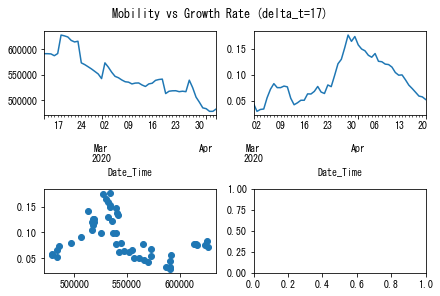

18 2020-02-12 00:00:00 2020-04-03 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


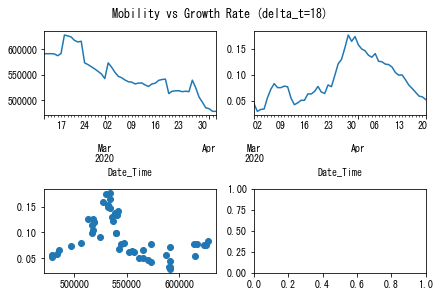

19 2020-02-11 00:00:00 2020-04-02 00:00:00 2020-03-01 00:00:00 2020-04-21 00:00:00 (52,) (52,)


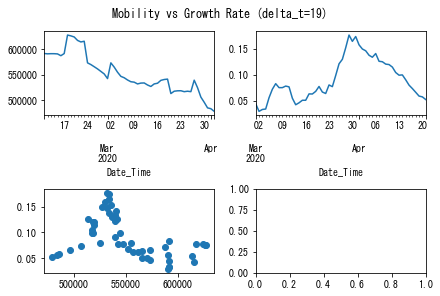

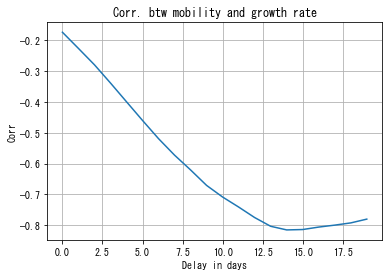

time: 20.9 s


In [12]:
# Caculate correlations between mobility and growth rate of confirmed cases

import datetime 

daily_mobility = mobility_2020.resample('1D').mean().rolling(7).mean()
# display(daily_confirmed_cases)

last_date_mobility = daily_mobility.index[-1]
last_date_confirmed = daily_confirmed_cases.index[-1]
first_date_confirmed = daily_confirmed_cases.index[0]
min_delay = last_date_confirmed - last_date_mobility
days_in_confirmed_cases = last_date_confirmed - first_date_confirmed
print("last date in mobility =",last_date_mobility)
print("last date confirmed =", last_date_confirmed )
print("first date confirmed =", first_date_confirmed )
print("min_delay = ", min_delay.days)
print("days in confirmed_cases =", days_in_confirmed_cases)

w = 20 # max delta t
corr = np.zeros(w)
for delta_t in range(min_delay.days, w):
    s0 = first_date_confirmed - datetime.timedelta(days=delta_t)
    e0 = s0 + days_in_confirmed_cases
    m = daily_mobility["L1"][s0:e0]
    s1 = s0 + datetime.timedelta(days=delta_t)
    e1 = e0 + datetime.timedelta(days=delta_t)
    g = daily_confirmed_cases["GrowthRate"][s1:e1]
    print(delta_t, s0, e0, s1, e1, m.shape, g.shape)
    corr[delta_t] = m.corr(g)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle("Mobility vs Growth Rate (delta_t={})".format(delta_t))
    m.plot(ax=axs[0, 0])
    g.plot(ax=axs[0, 1])
    axs[1, 0].scatter(m, g)
    plt.show()
    # print(d, len(n_calls), len(n_reported), corr[d])

plt.grid()
plt.title("Corr. btw mobility and growth rate")
plt.xlabel("Delay in days")
plt.ylabel("Corr")
plt.plot(np.array(range(min_delay.days, w)), corr[min_delay.days:w])

(28,) (23,)


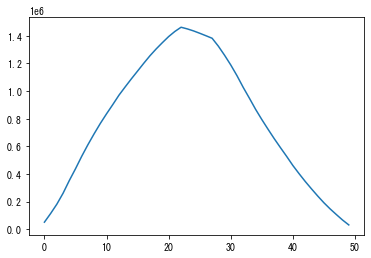

time: 347 ms


In [13]:
import sklearn
m = daily_mobility["L1"]["2020-03-20":"2020-04-16"]
g = daily_confirmed_cases["GrowthRate"]["2020-03-25":"2020-04-16"]
print(m.shape, g.shape)
plt.plot(np.convolve(g, m))

# Statistics on Mobility Data


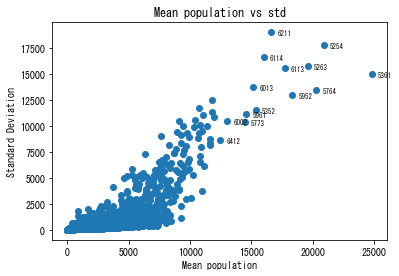

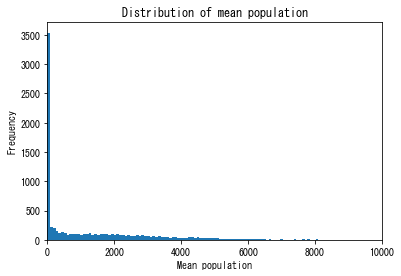

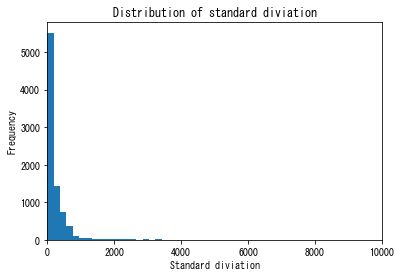

Large mean grids
533945361    24805.977307
533945254    20890.444568
533945764    20286.251488
533945263    19573.064360
533935952    18323.435640
533946113    17730.446801
533946211    16623.679688
533946114    16004.068824
533945352    15335.315476
533946013    15152.112351
533935961    14566.312128
533945773    14444.233259
533946002    13005.395461
533946412    12443.587426
533946004    11950.770833
533946111    11770.940848
533946212    11761.751488
533945351    11620.095610
533946312    11618.206845
533946314    11613.232515
533946011    11369.232887
533935764    11122.491071
533946001    11016.056548
533945363    10994.020833
533935591    10962.011161
533935863    10912.010045
533935854    10845.708705
533946214    10791.203869
533945771    10779.877604
533946213    10742.398810
533945253    10706.320312
533936903    10649.904018
533946112    10392.636161
533945093    10306.899926
533943333    10198.730655
533945362    10072.950149
dtype: float64
Large std grids
533946211    190

Index(['533935952', '533935961', '533945254', '533945263', '533945352',
       '533945361', '533945764', '533945773', '533946002', '533946013',
       '533946113', '533946114', '533946211', '533946412'],
      dtype='object')

time: 1.48 s


In [14]:
mean = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).std()



plt.title("Mean population vs std")
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std)
large_mean = mean[mean>12000]
for mesh in large_mean.index:
    plt.text(mean[mesh]+500, std[mesh]-300, str(mesh)[-4:], fontsize=7 )

plt.show()

plt.title("Distribution of mean population")
plt.xlabel("Mean population")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(mean, bins=300)
# plt.plot(mean.cumsum())
plt.show()

plt.title("Distribution of standard diviation")
plt.xlabel("Standard diviation")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(std, bins=100)
plt.show()

mobility_2020
print("Large mean grids")
print(mean[mean>10000].sort_values(ascending=False))
print("Large std grids")
print(std[std>15000].sort_values(ascending=False))

large_mean.index

- 平均人口が最も多いのは歌舞伎町 The largest mean populatioin is at Kabuki-cho (533945361    27699.655220)
- 標準偏差が最も大きいのは大手町 The largest standard diviation is at Otemachi（533946211    20066.947698）

You can check the location of a meshcode at [Geocode Viewer](http://www.geosense.co.jp/map/tool/geoconverter.php) 

まあ、そうだろう、という感じ The results are no surprise.

533945361 歌舞伎町 24805.97730654762 14962.4224598366
533946211 大手町 16623.6796875 19001.52357291299
533934771 成城学園前 1649.2767857142858 232.23105711688748
533935431 八雲 3860.7008928571427 575.7018724081564


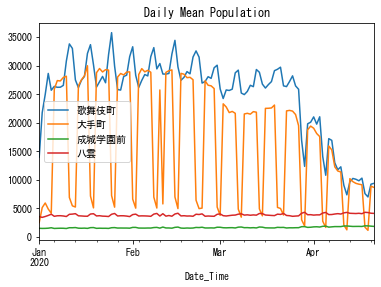

time: 251 ms


In [15]:
# Plot daily mean population for selected grid cells

focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
to_plot = mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .resample('1D').mean()

to_plot .plot()
plt.title("Daily Mean Population")
to_plot.std()
for key in focused_grids:
    print(key,focused_grids[key], mean[key], std[key] )


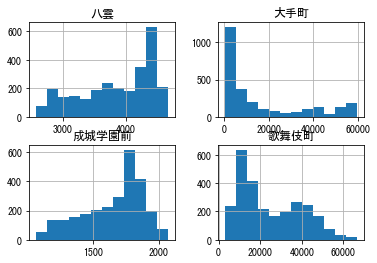

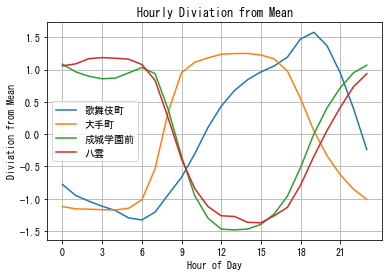

Index(['歌舞伎町', '大手町', '成城学園前', '八雲'], dtype='object')

time: 1.67 s


In [16]:
# Other statistics for selected grid cells

from sklearn import preprocessing

focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
# focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
# 歌舞伎町と大手町の人口ヒストグラム
mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .hist(bins=12)
plt.show()

hour_of_day = mobility_2020.groupby(mobility_2020.index.hour).mean()
hour_of_day = hour_of_day[list(focused_grids.keys())] \
    .rename(columns=focused_grids)


h = preprocessing.scale(hour_of_day)
for i in range(len(hour_of_day.columns)):
    plt.plot(range(24),h[:, i],label=hour_of_day.columns[i])
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 24, step=3))
plt.title("Hourly Diviation from Mean")
plt.xlabel("Hour of Day")
plt.ylabel("Diviation from Mean")
plt.show()
hour_of_day.columns

## Correlation with onset dates

- Data source:  [Jag Japan](https://gis.jag-japan.com/covid19jp/)

Unfortunately the data has no onset date for recent Tokyo cases.

last_date= 2020-04-22 00:00:00 n_records= 11640
3439


受診都道府県    217
dtype: int64

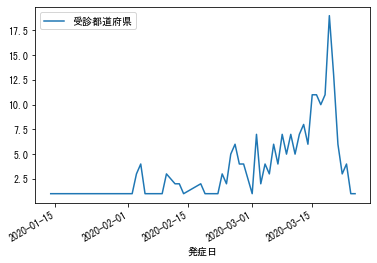

time: 1.09 s


In [17]:
# Correlation with onset dates

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)
fn = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
# fn = 'data/JAG_Japan/COVID-19.csv'

def read_data():
    d = pd.read_csv(fn,usecols=["確定日", "発症日", "受診都道府県"],parse_dates=["確定日", "発症日"])
    d = d.drop(["不明", "中部国際空港", "成田空港", "羽田空港", "関西国際空港"], errors='ignore')
    return d


jag_report = read_data()
last_date = jag_report["確定日"].max()
print("last_date=", last_date, "n_records=", len(jag_report))
jag_report = jag_report.drop(columns=["確定日"])
print(len(jag_report[jag_report["受診都道府県"]=="東京都"]))
onset = jag_report[jag_report["受診都道府県"]=="東京都"].groupby("発症日").count()
onset.plot()
onset.sum()

発症日のデータを取ってみたが、東京都の症例では、最近は発症日が記入されていない。このため、よい相関が取れない。あきらめ。


In [18]:
# Experimantal code. Please ignore
if 0: 

    fig, ax1 = plt.subplots()

    # ヒストグラムプロットとビン情報の取得
    n, bins, patches = ax1.hist(mean, alpha=0.7, label='Frequency', bins=20)
    ax1.grid(axis='x')
    ax1.set_xlabel("Grid Population")
    ax1.set_ylabel("Frequency")

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax1.twinx()
    lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
             label='Cumulative ratio')
    ax2.grid(visible=True)
    ax2.set_ylabel("Cumulative %")

    plt.show()

time: 2 ms


In [19]:
# Experimantal code. Please ignore

if 0: 
    ranked_means = mean.sort_values(ascending=False)
    # print(ranked_means)
    total = ranked_means.sum()
    print("sum=", total)
    top_n = 100

    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(top_n), ranked_means[:top_n])
    ax2 = ax1.twinx()
    ax2.plot(ranked_means[:top_n].cumsum() / total)
    plt.show()

time: 1.02 ms


In [20]:
# Experimantal code. Please ignore

if 0: 
    # 平成25年住宅・土地統計調査 確報集計
    print(pd.__version__)
    fn = 'data/estat/FEH_00200522_200408215652.csv'

    def read_data():
        d = pd.read_csv(fn, skiprows=14, sep=',', usecols=["H25地域", "世帯の年間収入階級_2013", "総数" ], 
                        thousands=',', encoding="SHIFT-JIS")
        d["総数"] = d["総数"].str.replace(',', '')
        d["総数"] = d["総数"].str.replace('-', '0')  #  '-' はゼロと解釈
        d["総数"] = d["総数"].astype(int)
        return d

    rank = [0, 100, 200, 300, 400, 500, 700, 1000, 1500]
    # rank = [50, 150, 250, 350, 450, 600, 850, 1250, 1500]

    def median(total, counts):
        # print("total=", total, "counts=", counts)
        h = total / 2
        c = 0
        for i in range(len(counts)):
            c += counts.values[i]
            if c > h:
                return rank[i]
        return None

    household_income = read_data()
    # print(household_income["総数"])
    n_records = len(household_income)
    meds = np.zeros(n_records)
    for i in range(0, n_records, 10):
    # for i in range(0, 1, 10):
        # print(household_income.iloc[i]["H25地域"])
        m = median(household_income.iloc[i]["総数"], household_income.iloc[i+1:i+10]["総数"])
        meds[i] = m

    household_income["Median"] = meds

    household_income


time: 3 ms


## Research Question: Which areas show larger mobility changes due to COVID-19?

1. Cluster grid cells on 2019 data
- Define mobility reduction
    - Take two time points, $t_1$ and $t_2$, and compute the mobility difference $\Delta = d(m(t_1), m(t_2))$
    - Let's take three Tuesdays, $t_0=$ Feb 4 (before Diamond Princess), $t_1$ = Mar 3 (after school closure), and $t_2=$ Mar 31 (lockdown imminent).
    - Calculate $\Delta = d(m(t_0), m(t_1))$ and $\Delta = d(m(t_0), m(t_2))$ for every cell

Using saved cluster f:/Users/Hiroshi/Desktop/DoCoMo/cache/cluster.pickle


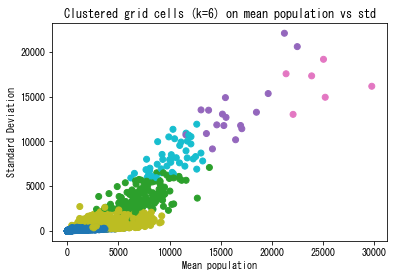

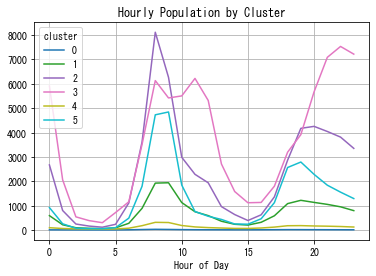

time: 1.34 s


In [24]:
# Cluster grid cells

from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
import pickle
import os

mobility_2019_L1 = mobility_2019.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()
mobility_2019_L1_daily = mobility_2019_L1.groupby(mobility_2019_L1.index.hour).mean()

# display(mobility_2019_L1_daily.columns)
# If already clustered, use them

cluster_fn = cache_dir + 'cluster.pickle'
n_clusters = 6
if os.path.exists(cluster_fn):
    with open(cluster_fn, 'rb') as f:
        pred = pickle.load(f)
    print('Using saved cluster', cluster_fn)
else:
    pred = KMeans(n_clusters=n_clusters).fit_predict(mobility_2019_L1_daily.values.T)
    pred = pd.DataFrame(pred.astype(int), index=mobility_2019_L1_daily.columns)
    print(pred)
    with open(cluster_fn, 'wb') as f:
        pickle.dump(pred, f)

mean = mobility_2019.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2019.drop(columns=["L1", "L2", "mean", "std"]).std()

cmap = plt.get_cmap("tab10")

# Scatter Plot between mean and std
plt.title("Clustered grid cells (k={}) on mean population vs std".format(n_clusters))
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std, c=pred, cmap=cmap)
mobility_2019_L1_daily_t = mobility_2019_L1_daily.T
mobility_2019_L1_daily_t["cluster"] = pred

# Hourly population by Cluster
title = "Hourly Population by Cluster"
mobility_2019_L1_daily_t.groupby("cluster").mean().T.plot(title=title, cmap=cmap, grid=True)
plt.xlabel("Hour of Day")
plt.show()

clustered_cells = mobility_2019_L1_daily_t["cluster"]
clustered_cells_df = pd.DataFrame(clustered_cells).reset_index().rename(columns={"index": "meshcode"})


## Plot results on map
- This code is by Kunihiko Miyoshi (https://github.com/colspan)

- Data source: 
    - 国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
    - 国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html
    - GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


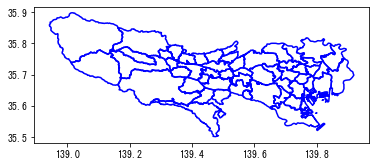

time: 4.06 s


In [25]:
# This code is by Kunihiko Miyoshi (https://github.com/colspan)
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

%matplotlib inline
%load_ext autotime

pref_name_def = {
    "01": {
        "name_jp": "北海道",
        "name_en": "Hokkaido"
    },
    "02": {
        "name_jp": "青森県",
        "name_en": "Aomori"
    },
    "03": {
        "name_jp": "岩手県",
        "name_en": "Iwate"
    },
    "04": {
        "name_jp": "宮城県",
        "name_en": "Miyagi"
    },
    "05": {
        "name_jp": "秋田県",
        "name_en": "Akita"
    },
    "06": {
        "name_jp": "山形県",
        "name_en": "Yamagata"
    },
    "07": {
        "name_jp": "福島県",
        "name_en": "Fukushima"
    },
    "08": {
        "name_jp": "茨城県",
        "name_en": "Ibaraki"
    },
    "09": {
        "name_jp": "栃木県",
        "name_en": "Tochigi"
    },
    "10": {
        "name_jp": "群馬県",
        "name_en": "Gunma"
    },
    "11": {
        "name_jp": "埼玉県",
        "name_en": "Saitama"
    },
    "12": {
        "name_jp": "千葉県",
        "name_en": "Chiba"
    },
    "13": {
        "name_jp": "東京都",
        "name_en": "Tokyo"
    },
    "14": {
        "name_jp": "神奈川県",
        "name_en": "Kanagawa"
    },
    "15": {
        "name_jp": "新潟県",
        "name_en": "Niigata"
    },
    "16": {
        "name_jp": "富山県",
        "name_en": "Toyama"
    },
    "17": {
        "name_jp": "石川県",
        "name_en": "Ishikawa"
    },
    "18": {
        "name_jp": "福井県",
        "name_en": "Fukui"
    },
    "19": {
        "name_jp": "山梨県",
        "name_en": "Yamanashi"
    },
    "20": {
        "name_jp": "長野県",
        "name_en": "Nagano"
    },
    "21": {
        "name_jp": "岐阜県",
        "name_en": "Gifu"
    },
    "22": {
        "name_jp": "静岡県",
        "name_en": "Shizuoka"
    },
    "23": {
        "name_jp": "愛知県",
        "name_en": "Aichi"
    },
    "24": {
        "name_jp": "三重県",
        "name_en": "Mie"
    },
    "25": {
        "name_jp": "滋賀県",
        "name_en": "Shiga"
    },
    "26": {
        "name_jp": "京都府",
        "name_en": "Kyoto"
    },
    "27": {
        "name_jp": "大阪府",
        "name_en": "Osaka"
    },
    "28": {
        "name_jp": "兵庫県",
        "name_en": "Hyogo"
    },
    "29": {
        "name_jp": "奈良県",
        "name_en": "Nara"
    },
    "30": {
        "name_jp": "和歌山県",
        "name_en": "Wakayama"
    },
    "31": {
        "name_jp": "鳥取県",
        "name_en": "Tottori"
    },
    "32": {
        "name_jp": "島根県",
        "name_en": "Shimane"
    },
    "33": {
        "name_jp": "岡山県",
        "name_en": "Okayama"
    },
    "34": {
        "name_jp": "広島県",
        "name_en": "Hiroshima"
    },
    "35": {
        "name_jp": "山口県",
        "name_en": "Yamaguchi"
    },
    "36": {
        "name_jp": "徳島県",
        "name_en": "Tokushima"
    },
    "37": {
        "name_jp": "香川県",
        "name_en": "Kagawa"
    },
    "38": {
        "name_jp": "愛媛県",
        "name_en": "Ehime"
    },
    "39": {
        "name_jp": "高知県",
        "name_en": "Kochi"
    },
    "40": {
        "name_jp": "福岡県",
        "name_en": "Fukuoka"
    },
    "41": {
        "name_jp": "佐賀県",
        "name_en": "Saga"
    },
    "42": {
        "name_jp": "長崎県",
        "name_en": "Nagasaki"
    },
    "43": {
        "name_jp": "熊本県",
        "name_en": "Kumamoto"
    },
    "44": {
        "name_jp": "大分県",
        "name_en": "Oita"
    },
    "45": {
        "name_jp": "宮崎県",
        "name_en": "Miyazaki"
    },
    "46": {
        "name_jp": "鹿児島県",
        "name_en": "Kagoshima"
    },
    "47": {
        "name_jp": "沖縄県",
        "name_en": "Okinawa"
    },
}

# define functions

def meshcode_to_latlng(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = float((int(meshcode[8])-1) // 2) * 1.0/8.0/10.0/2.0/1.5
        half_lon = float((int(meshcode[8])-1) % 2) * 1.0/8.0/10.0/2.0
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = float(meshcode[0:2])/1.5 + float(meshcode[4]) * \
        1.0/8.0/1.5 + float(meshcode[6])*1.0/8.0/10.0/1.5 + half_lat
    longtitude = float(meshcode[2:4])+100.0 + float(meshcode[5]) * \
        1.0/8.0 + float(meshcode[7])*1.0/8.0/10.0 + half_lon
    return (latitude, longtitude)


def meshcode_to_latlng_index(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = (int(meshcode[8])-1) // 2
        half_lon = (int(meshcode[8])-1) % 2
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = int(meshcode[0:2])*8*10*2 + int(meshcode[4]
                                               )*10*2 + int(meshcode[6])*2 + half_lat
    longtitude = int(meshcode[2:4])*8*10*2 + \
        int(meshcode[5])*10*2 + int(meshcode[7])*2 + half_lon
    return (latitude, longtitude)

def llindex_to_latlng(lli):
    return (
        float(lli[0]) / 2 / 8 / 10 / 1.5,
        float(lli[1]) / 2 / 8 / 10 + 100)

def meshcode_to_polygon(meshcode):
    south_west_i = meshcode_to_latlng_index(meshcode)

    lat_i, lon_i = south_west_i
    diff = 1 if len(meshcode) == 9 else 2
    north_east_i = (lat_i + diff, lon_i + diff)
    sw_geo = llindex_to_latlng(south_west_i)
    ne_geo = llindex_to_latlng(north_east_i)

    coordinates = [
        [sw_geo[1], sw_geo[0]],
        [sw_geo[1], ne_geo[0]],
        [ne_geo[1], ne_geo[0]],
        [ne_geo[1], sw_geo[0]],
        [ne_geo[1], sw_geo[0]]
    ]
    return coordinates

df_tokyo = gpd.read_file('data/JapanCityGeoJason/13_tokyo.json')
# 重複を除外する
df_tokyo = df_tokyo[df_tokyo['id']!='13']
# 諸島を除外する
df_tokyo = df_tokyo[df_tokyo['id'].apply(lambda x: int(x)<13361)]

# 注意 : このデータを利用するには下記クレジットが必要
'''
国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html

GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson
'''
# 地図を描画
ax = df_tokyo.boundary.plot(color='blue')



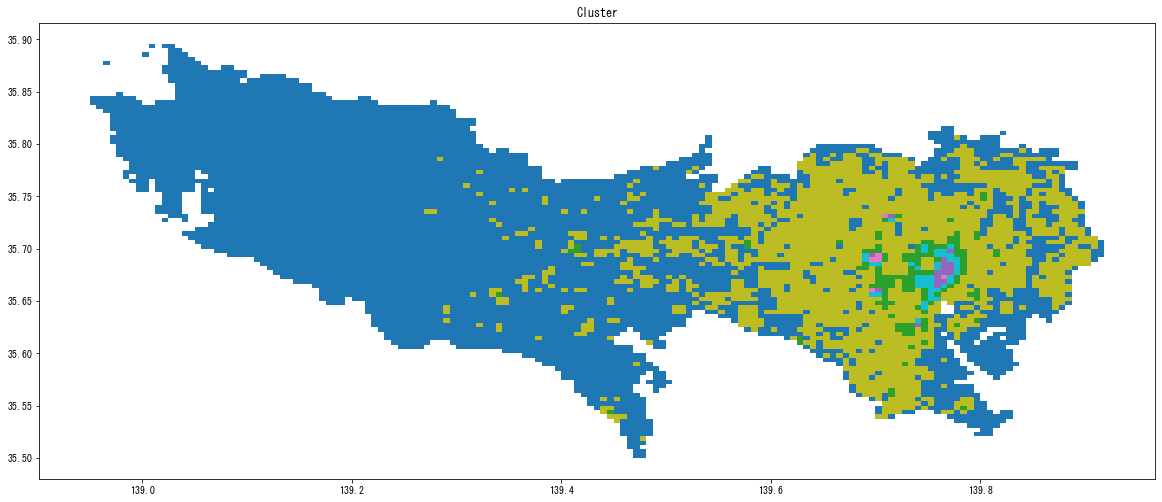

time: 1.48 s


In [26]:
from shapely.geometry import Polygon
# figsize_save = plt.rcParams['figure.figsize']
def show_cells_on_map(df, column, cmap=cmap, title=None, legend=False, legend_kwds=None):
    # df should have "meshcode" for meshcode and column for the data to be displayed
    plt.rcParams['figure.figsize'] = (20, 10)
    # 島しょ部を除外する
    df_poplog_geo = df[df.meshcode > '530000000']
    df_poplog_geo = gpd.GeoDataFrame(df_poplog_geo)

    # meshcodeに対応するポリゴンを生成する
    df_poplog_geo['geometry'] = df_poplog_geo['meshcode'].apply(lambda x: Polygon(meshcode_to_polygon(x)))  

    ax = df_poplog_geo.plot(column=column, cmap=cmap, legend=legend, legend_kwds=legend_kwds)
    plt.title(title)
    plt.rcParams['figure.figsize'] = default_figsize
    
show_cells_on_map(clustered_cells_df, 'cluster', title="Cluster")

cluster,0.0,1.0,2.0,3.0,4.0,5.0
2020-03-03,-0.066951,-0.120993,-0.127845,-0.130605,-0.114539,-0.079333
2020-03-31,-0.135969,-0.280828,-0.313900,-0.346636,-0.238464,-0.234560
2020-04-19,-0.095294,-0.572210,-0.633575,-0.681309,-0.427097,-0.564348


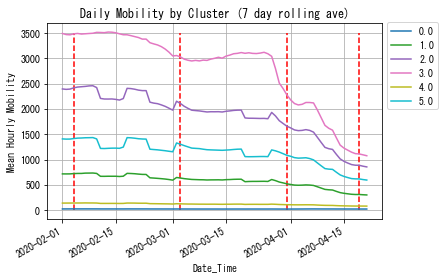

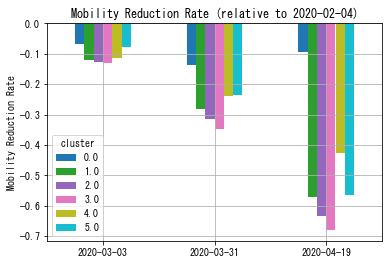

count    8519.000000
mean       29.833700
std       126.748330
min       -28.732143
25%        -2.020833
50%         1.803571
75%        25.032738
max      2617.452381
Name: reduction, dtype: float64


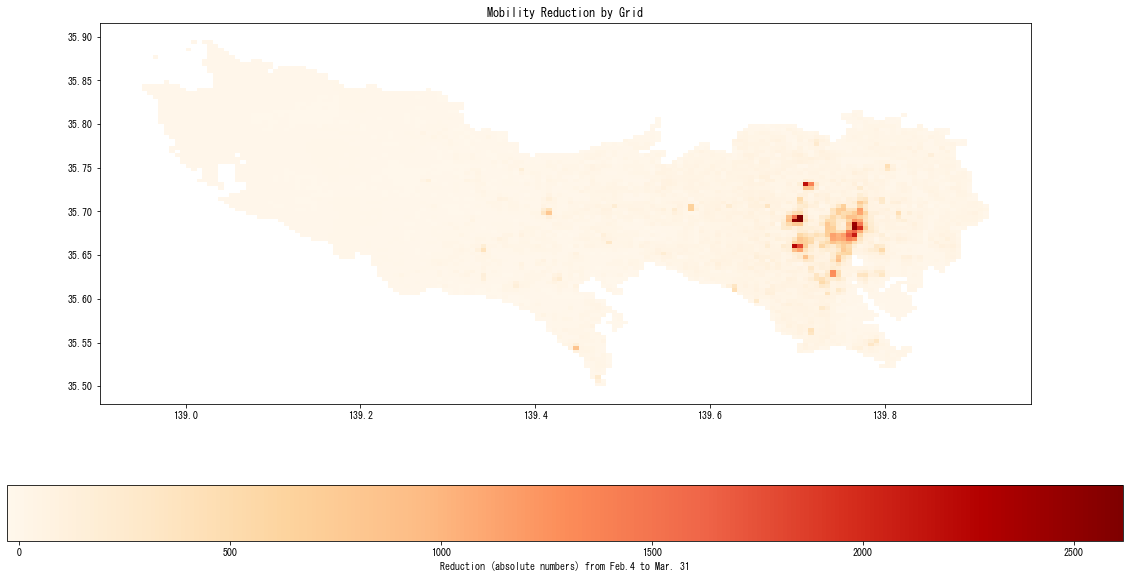

time: 3.85 s


In [28]:
# Mobility Time Series by Cluster
window = 7
reference_dates = pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-19'])
mobility_2020_L1 = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()

mobility_by_cells = mobility_2020_L1.resample('1D').mean().rolling(window).mean().loc['2020-2-1':].T
m = mobility_by_cells.copy()
m["cluster"] = pred
title = "Daily Mobility by Cluster ({} day rolling ave)".format(window)
mobility_by_cluster = m.groupby("cluster").mean().T
# print(mobility_by_cluster.shift(- (window // 2)))
# mobility_by_cluster.shift(- (window // 2)).plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
mobility_by_cluster.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.ylabel("Mean Hourly Mobility")
plt.vlines(reference_dates, 0, 3500, "red", linestyles='dashed')

# mobility reduction rate by cluster
m = mobility_by_cluster.T.loc[:,reference_dates]
for t in range(1, len(reference_dates)):
    m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0

display(m.drop(columns=reference_dates[0]).T)
m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
plt.title("Mobility Reduction Rate (relative to {})".format(reference_dates[0].date()))
plt.ylabel("Mobility Reduction Rate")
plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
plt.show()

# mobility reduction by cells
m = mobility_by_cells
reduction_by_cells = m[reference_dates[0]] - m[reference_dates[-1]] 
log_reduction_by_cells = np.log(reduction_by_cells - reduction_by_cells.min() + 1)
reduction_by_cells = reduction_by_cells.rename("reduction")
# reduction_by_cells["log_reduction"] = log_reduction_by_cells
print(reduction_by_cells.describe())
# reduction_by_cells.T.loc["533945361"]  # 歌舞伎町
reduction_by_cells = reduction_by_cells.reset_index().rename(columns={"index":"meshcode", 0:"t1", 1:"t2"})
#reduction_by_cells['t1'] = reduction_by_cells['t1'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells['t2'] = reduction_by_cells['t2'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells = reduction_by_cells.fillna(0)
show_cells_on_map(reduction_by_cells, 'reduction', title="Mobility Reduction by Grid",
                  legend_kwds={'label': "Reduction (absolute numbers) from Feb.4 to Mar. 31", 'orientation': "horizontal"},
                  cmap='OrRd', legend=True)

reduction_by_cells.to_csv(cache_dir + "mobility_reduction_by_cells.csv")


In [ ]:
cluster = 3
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle("Correlation between mobility in cluster {} and growth rate".format(cluster))
m = mobility_by_cluster.loc[:,cluster]
m.plot(ax=axs[0, 0])
c = daily_confirmed_cases["GrowthRate"]
c.plot(ax=axs[0, 1])
# axs[1,0].plot(c)
axs[1,1].plot(np.convolve(m, c, mode='valid'))
# daily_confirmed_cases

## Looking at time subcomponents
1. Day and night (6am-6pm, 6pm-6am)
- Weekdays and Weekends (+ holidays)

In [ ]:
# mobility_2020_L1[((mobility_2020_L1.index.hour < 6) or (18 <= mobility_2020_L1.index.hour))]
nighttime = pd.concat([mobility_2020_L1[mobility_2020_L1.index.hour < 6],
                mobility_2020_L1[mobility_2020_L1.index.hour >= 18]])
daytime = mobility_2020_L1[6 <= mobility_2020_L1.index.hour]
daytime = daytime[daytime.index.hour < 18]
print(len(daytime), len(nighttime))

daytime = daytime.T
daytime["cluster"] = pred
daytime_by_cluster = daytime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Day time mobility by clusters"
daytime_by_cluster.resample('1D').mean().rolling(7).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')

nighttime = nighttime.T
nighttime["cluster"] = pred
# print(nighttime)


nighttime_by_cluster = nighttime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Night time mobility by clusters"
nighttime_by_cluster.resample('1D').mean().rolling(7).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
# nighttime_by_cluster

In [ ]:
mobility_2020